In [1]:
import so

In [2]:
# Tags
filenames = ['android_c.csv', 'csharp_c.csv', 'java_c.csv', 'other_c.csv', 'python_c.csv', 'r_c.csv', 'web_c.csv']
tags = ['android', 'c#', 'java', 'other', 'python', 'r', 'web']

## Prepare/load the posting data

In [3]:
prepare_daily_data = False
tag_dfs = {}

if prepare_daily_data:
    df = so.load_data()
    so.did_prepare_data(df)
    print(df.info())
    
    questions = so.questions(df)
    answers = so.answers(df)

    q_outcomes = ['line_count', 'log_lc', 'ViewCount', 'Score']
    a_outcomes = ['line_count', 'log_lc', 'Score']
    q_daily = so.prepare_daily_data(questions, q_outcomes)
    a_daily = so.prepare_daily_data(answers, a_outcomes)

    q_daily.to_csv('data/csv/final/q_daily.csv', index=False)
    a_daily.to_csv('data/csv/final/a_daily.csv', index=False)

    # tags
    for tag, filename in zip(tags, filenames):
        print(f'Loading: {tag}')
        tag_df = so.load_data(filename=f'data/csv/tags/{filename}')
        so.did_prepare_data(tag_df, 'tags')
        print(tag_df.info())

        t_outcomes = ['line_count', 'log_lc', 'ViewCount', 'Score', 'loc', 'log_loc', 'Medium', 'Hard']
        tag_daily = so.prepare_daily_data(tag_df, t_outcomes)
        tag_daily.to_csv(f'data/csv/tags/{filename[:-4]}_daily.csv', index=False)
        tag_dfs[tag] = tag_daily
else:
    q_daily = so.load_data('data/csv/final/q_daily.csv', date_column='date')
    a_daily = so.load_data('data/csv/final/a_daily.csv', date_column='date')

    # tags
    for tag, filename in zip(tags, filenames):
        print(f'Loading: {tag}')
        tag_daily = so.load_data(f'data/csv/tags/{filename[:-4]}_daily.csv', date_column='date')
        tag_dfs[tag] = tag_daily

Loading: android
Loading: c#
Loading: java
Loading: other
Loading: python
Loading: r
Loading: web


## Run the regressions

In [4]:
dfs = {'questions': q_daily, 'answers': a_daily}
outcomes = {'questions': ['line_count', 'log_lc', 'ViewCount', 'Score'],
            'answers': ['line_count', 'log_lc', 'Score']}
start_dates = {}
masks = {}
results = {}

for type, df in dfs.items():
    print(f'Masks: {type}')
    start_dates[type], masks[type] = so.rolling_window_masks(df, data_column='date', normalized=True, window_days=30)    

for type, outcome_list in outcomes.items():
    for outcome in outcome_list:
        print(f'Processing: {type} - {outcome}')

        X, y = so.did_design_matrix(f'{outcome}_bar', dfs[type])
        res = so.did_wls(dfs[type], X, y, masks[type], start_dates[type], outcome)
        results[(type, outcome)] = res

Masks: questions
Masks: answers
Processing: questions - line_count
Processing: questions - log_lc
Processing: questions - ViewCount
Processing: questions - Score
Processing: answers - line_count
Processing: answers - log_lc
Processing: answers - Score


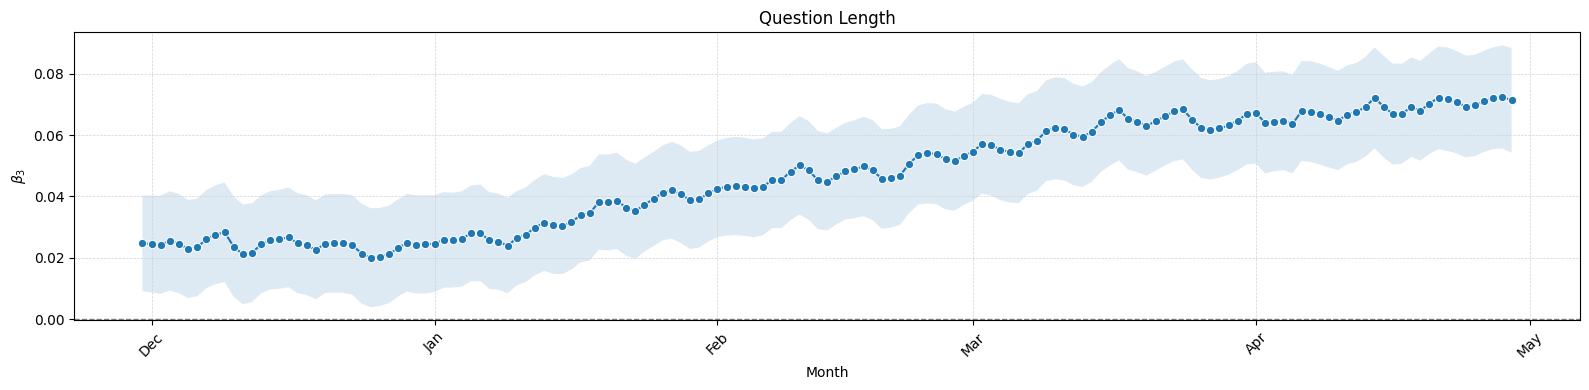

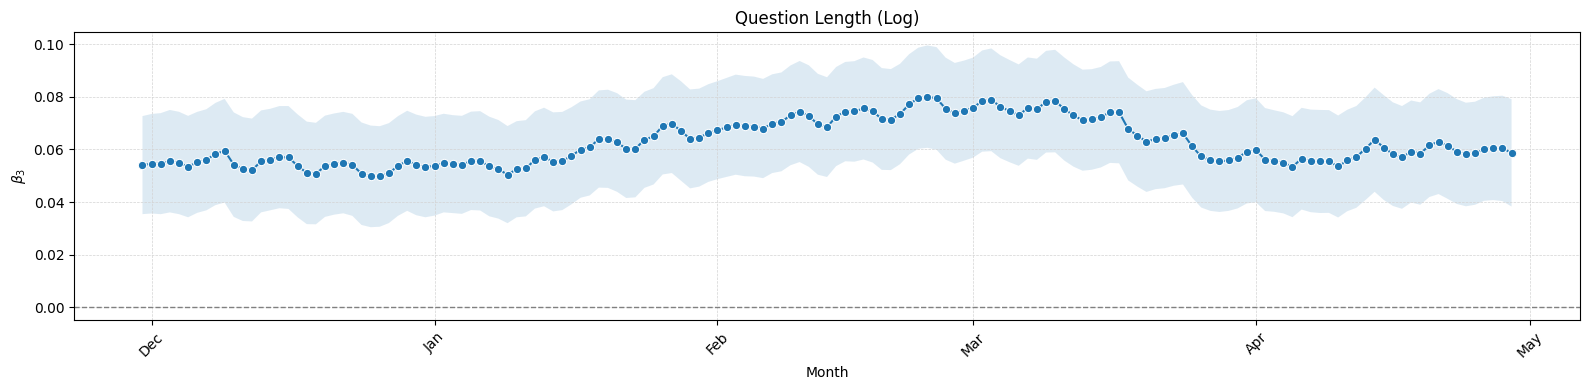

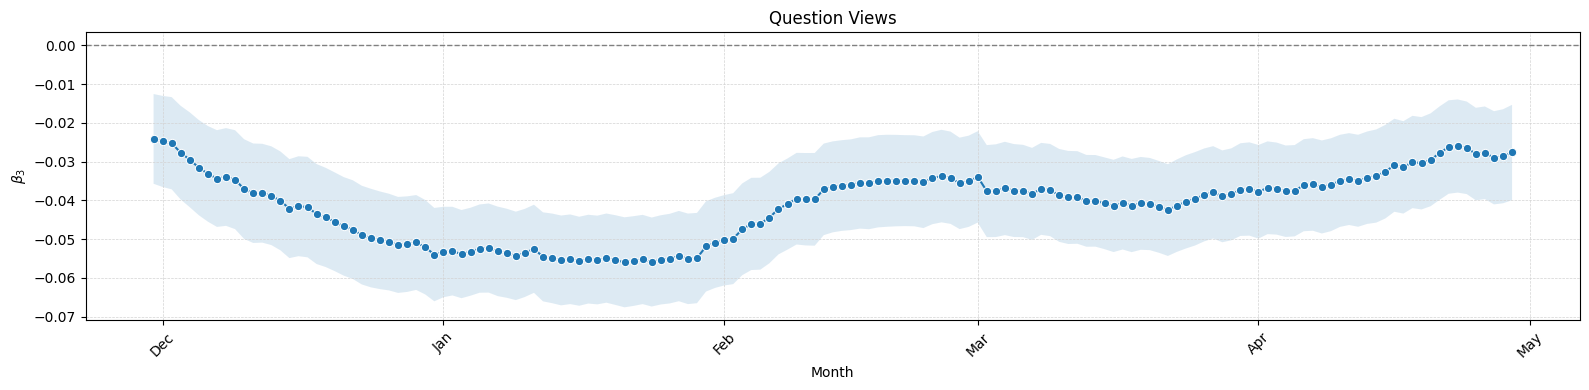

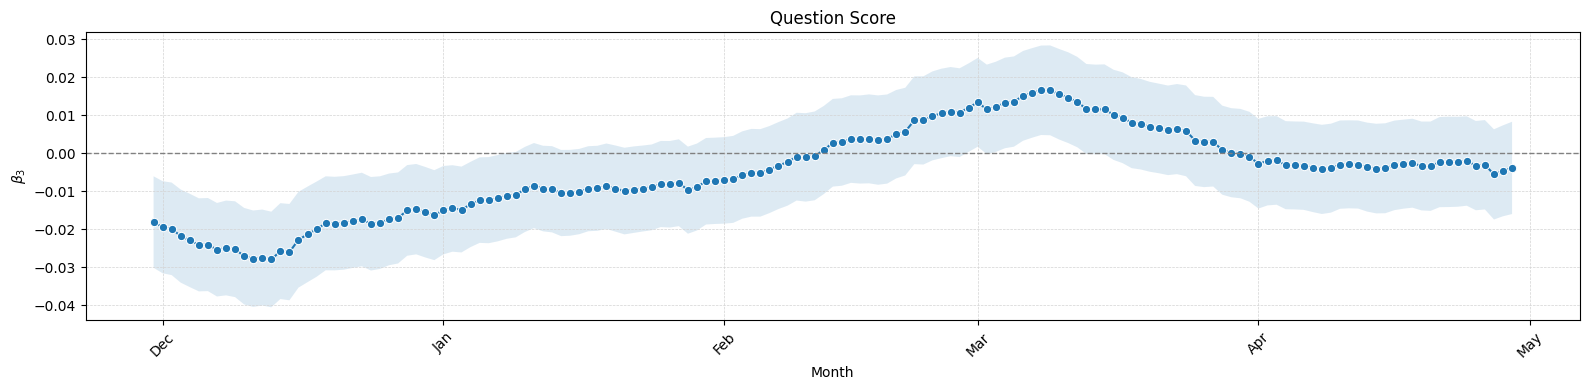

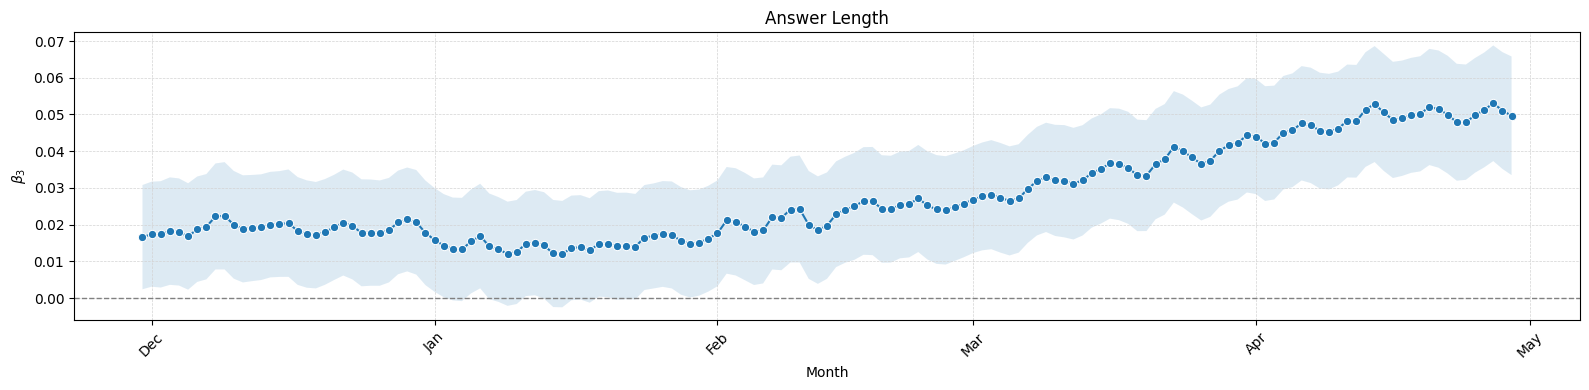

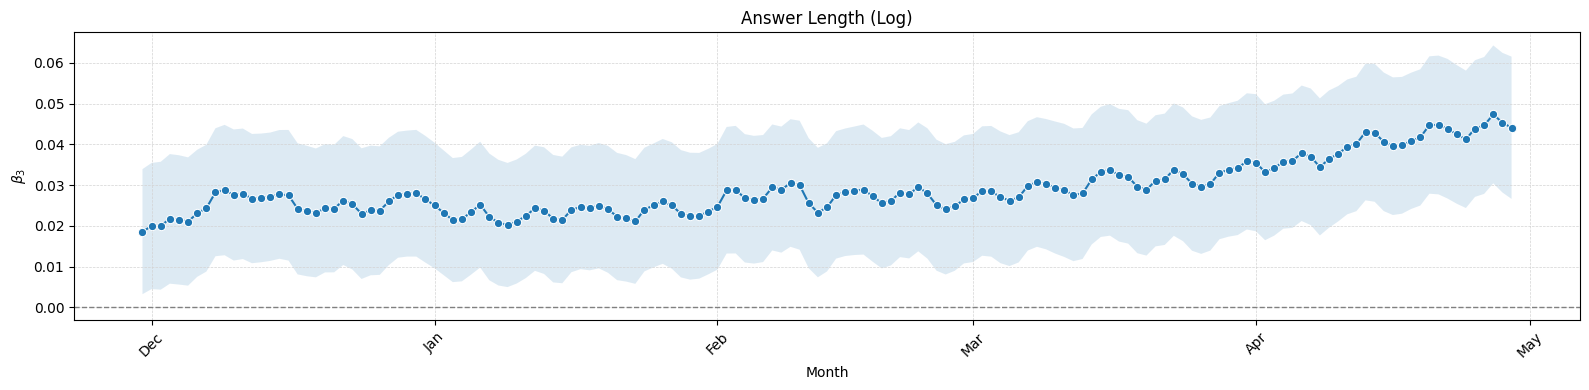

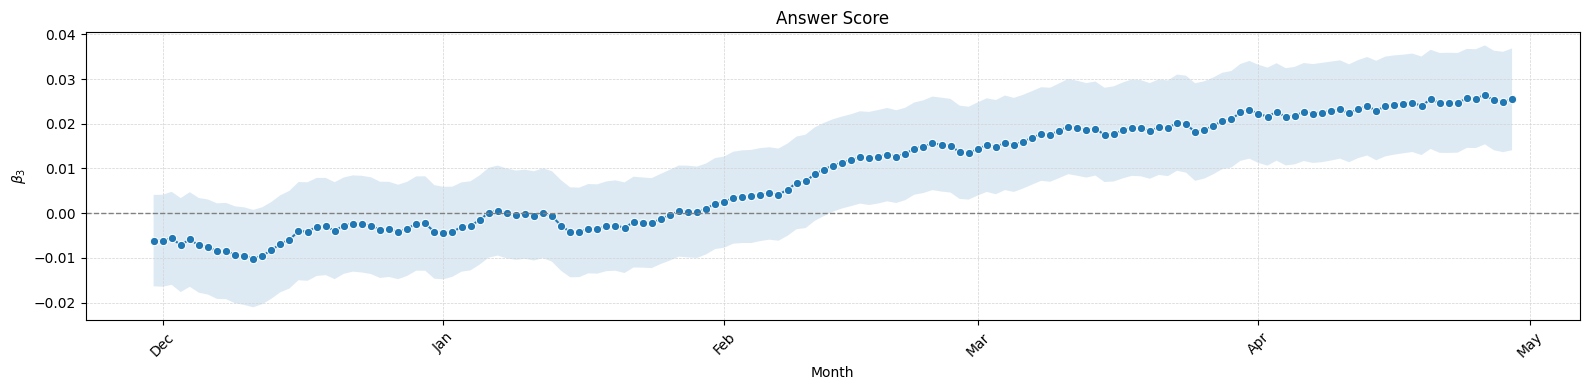

In [5]:
titles = {('questions', 'line_count'): ['Question Length', 'qlc_beta.pdf'],
           ('questions', 'log_lc'): ['Question Length (Log)', 'qllc_beta.pdf'],
           ('questions', 'ViewCount'): ['Question Views', 'qv_beta.pdf'],
           ('questions', 'Score'): ['Question Score', 'qs_beta.pdf'],
           ('answers', 'line_count'): ['Answer Length', 'alc_beta.pdf'],
           ('answers', 'log_lc'): ['Answer Length (Log)', 'allc_beta.pdf'],
           ('answers', 'Score'): ['Answer Score', 'as_beta.pdf']}

for key, df_res in results.items():
    so.plot_did(df_res, titles[key][0], titles[key][1])

## Run the regressions on the tag groups data

In [6]:
outcomes = ['line_count', 'log_lc', 'ViewCount', 'Score', 'loc', 'log_loc', 'Medium', 'Hard']
start_dates = {}
masks = {}
results = {}

for tag in tags:
    print(f'Masks: {tag}')
    start_dates[tag], masks[tag] = so.rolling_window_masks(tag_dfs[tag], data_column='date', normalized=True, window_days=30)     

for tag in tags:
    for outcome in outcomes:
        print(f'Processing: {tag} - {outcome}')

        X, y = so.did_design_matrix(f'{outcome}_bar', tag_dfs[tag])
        res = so.did_wls(tag_dfs[tag], X, y, masks[tag], start_dates[tag], outcome)
        results[(tag, outcome)] = res

Masks: android
Masks: c#
Masks: java
Masks: other
Masks: python
Masks: r
Masks: web
Processing: android - line_count
Processing: android - log_lc
Processing: android - ViewCount
Processing: android - Score
Processing: android - loc
Processing: android - log_loc
Processing: android - Medium
Processing: android - Hard
Processing: c# - line_count
Processing: c# - log_lc
Processing: c# - ViewCount
Processing: c# - Score
Processing: c# - loc
Processing: c# - log_loc
Processing: c# - Medium
Processing: c# - Hard
Processing: java - line_count
Processing: java - log_lc
Processing: java - ViewCount
Processing: java - Score
Processing: java - loc
Processing: java - log_loc
Processing: java - Medium
Processing: java - Hard
Processing: other - line_count
Processing: other - log_lc
Processing: other - ViewCount
Processing: other - Score
Processing: other - loc
Processing: other - log_loc
Processing: other - Medium
Processing: other - Hard
Processing: python - line_count
Processing: python - log_lc


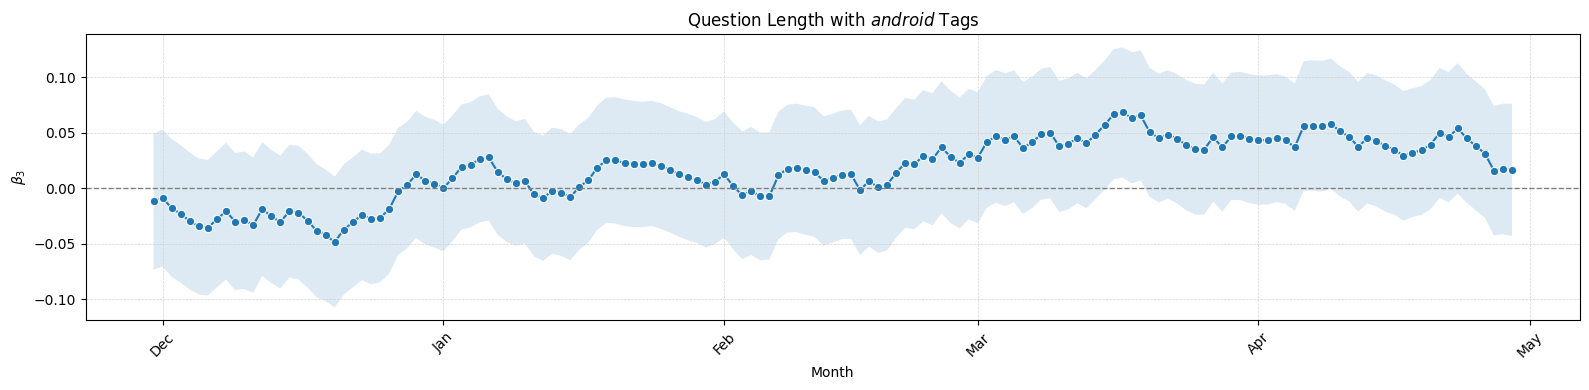

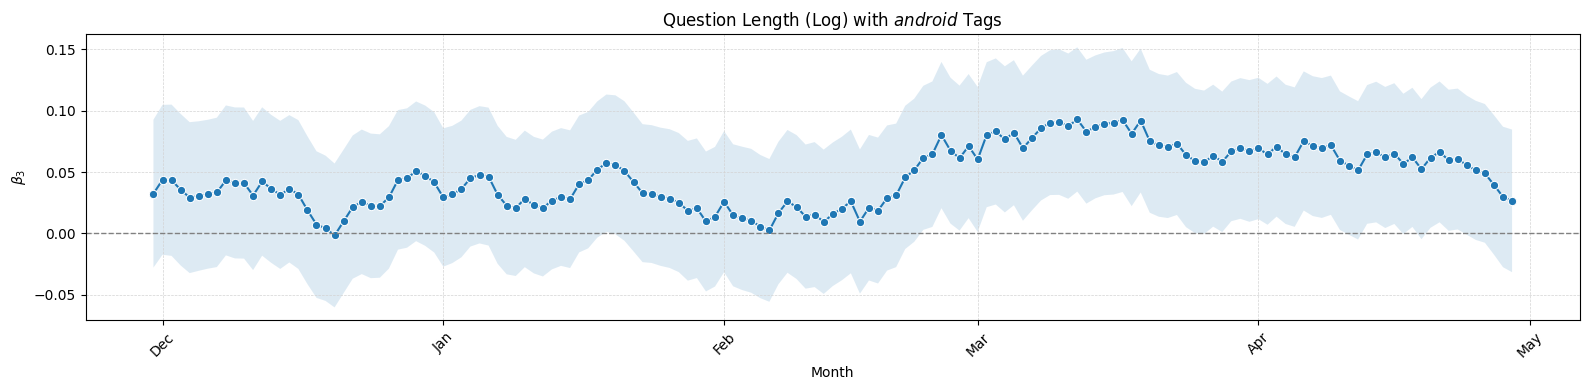

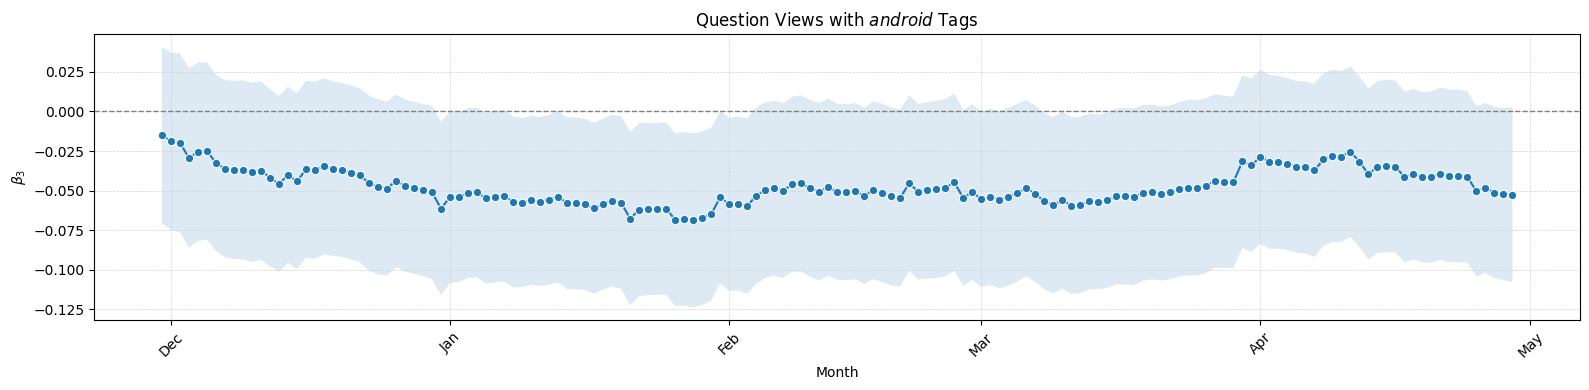

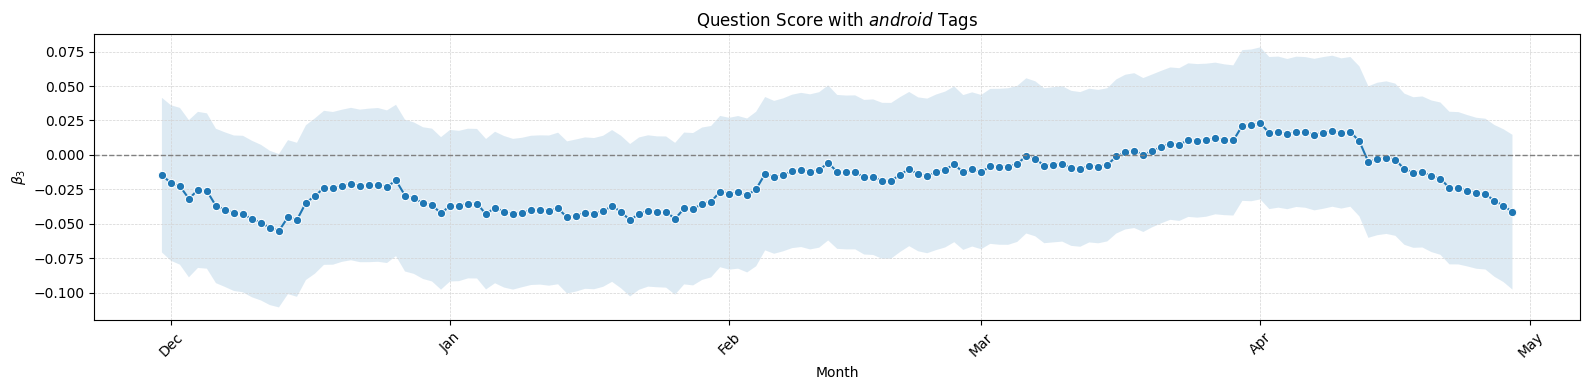

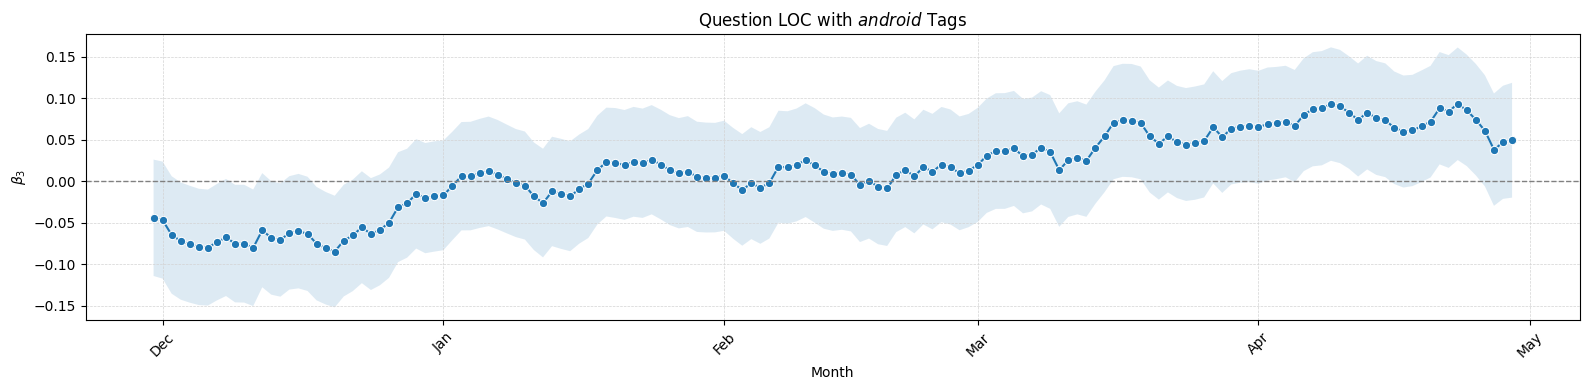

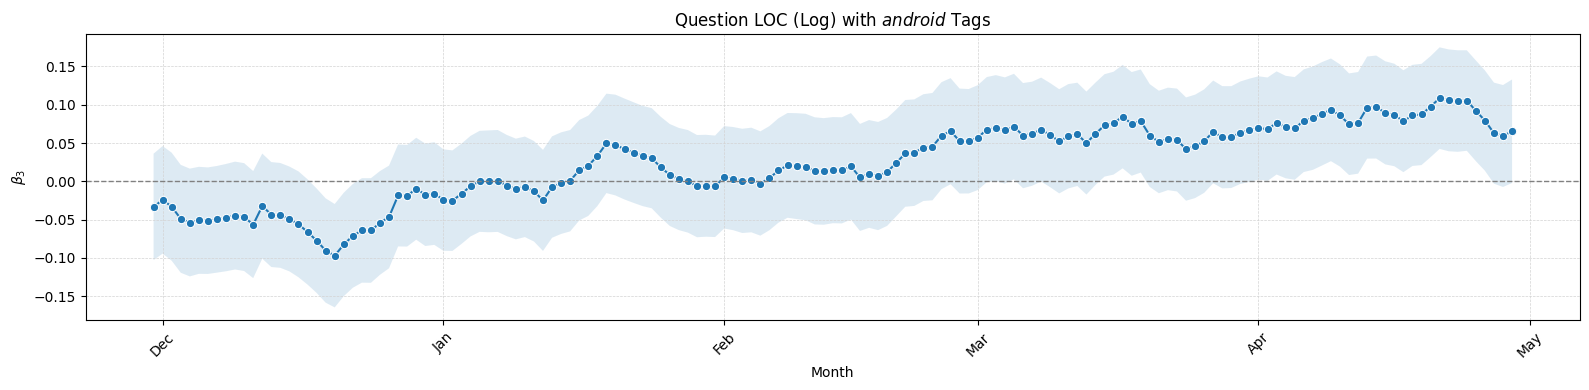

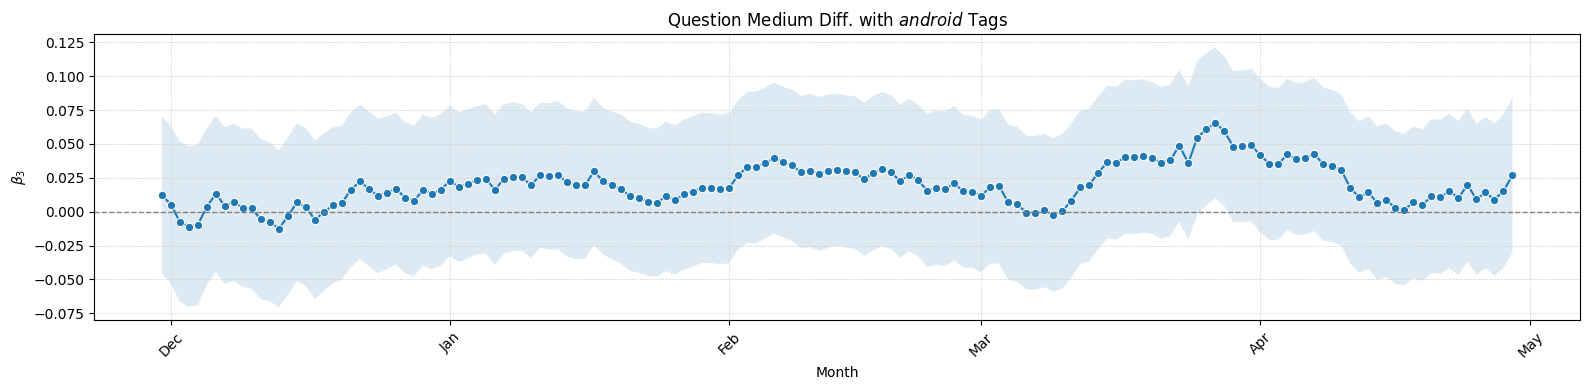

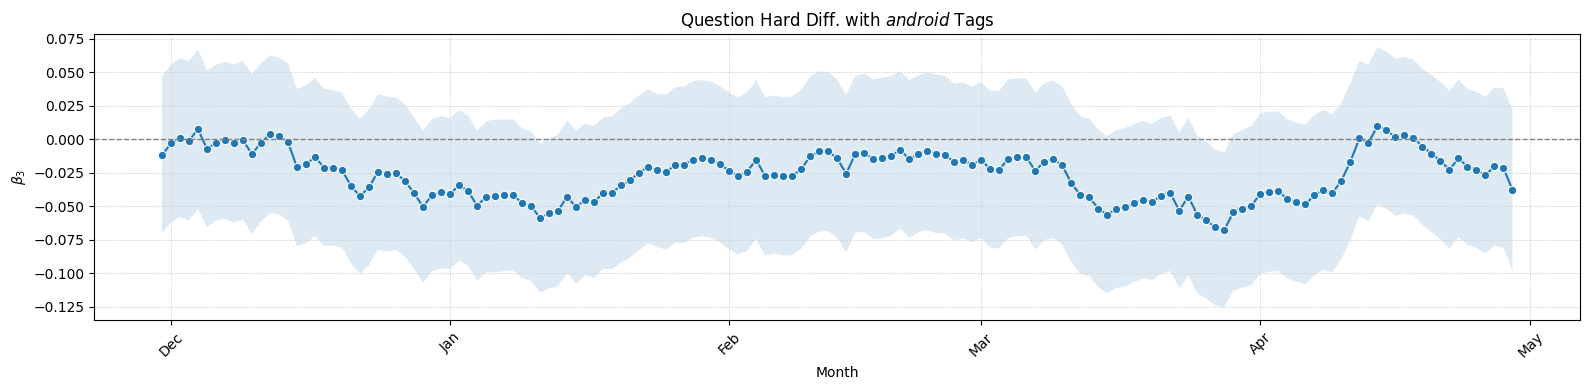

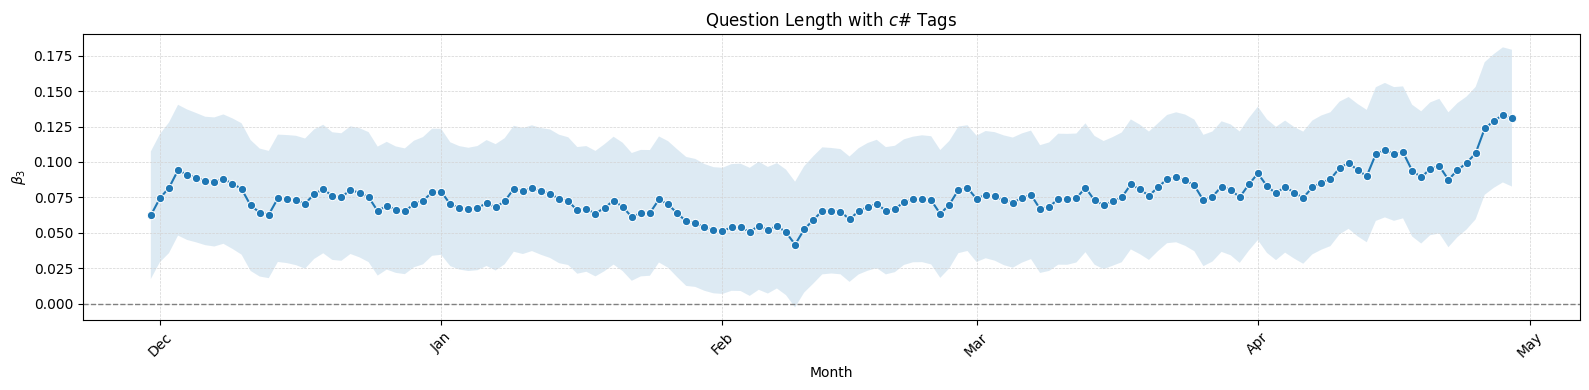

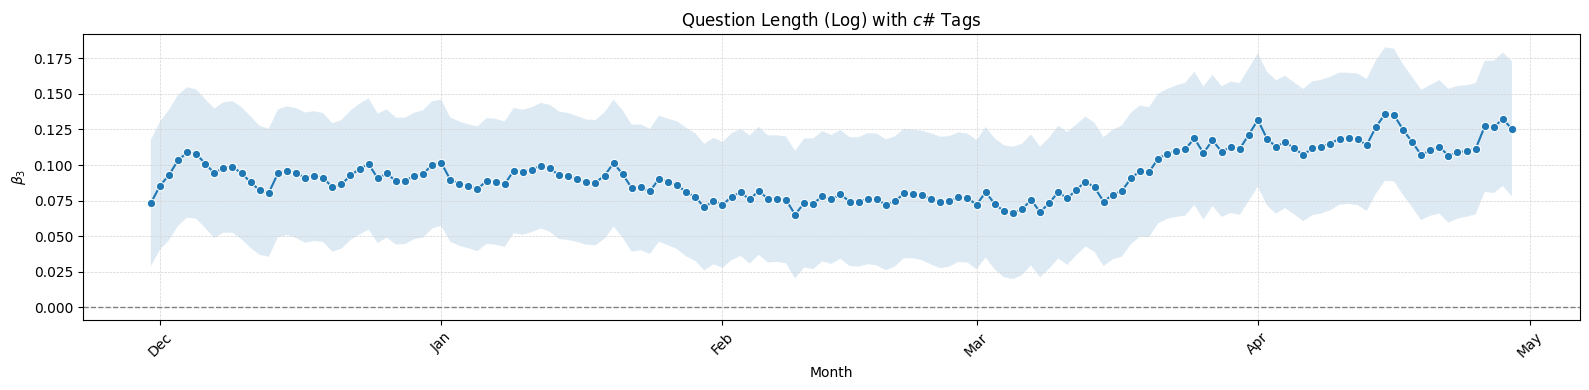

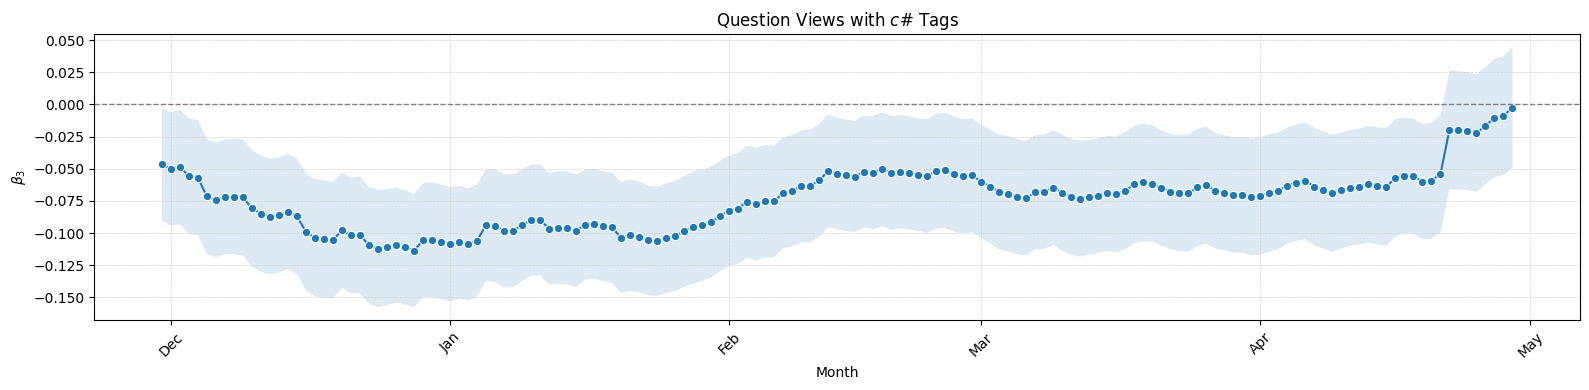

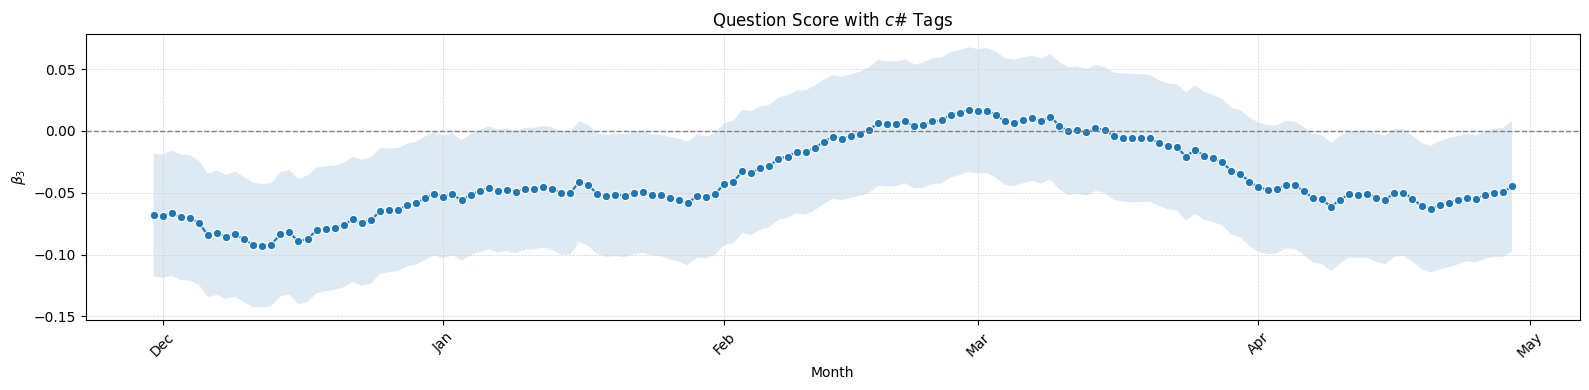

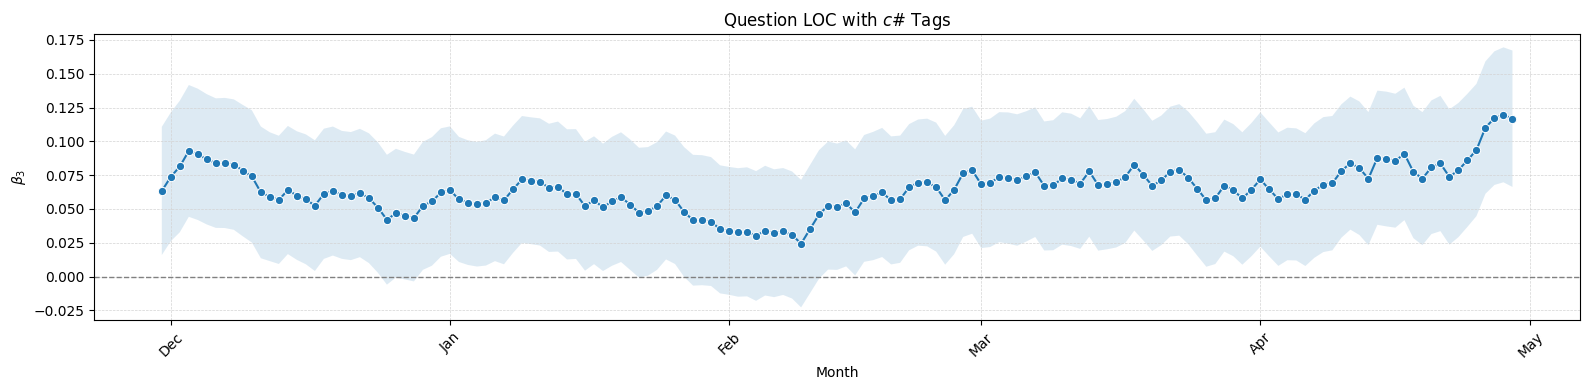

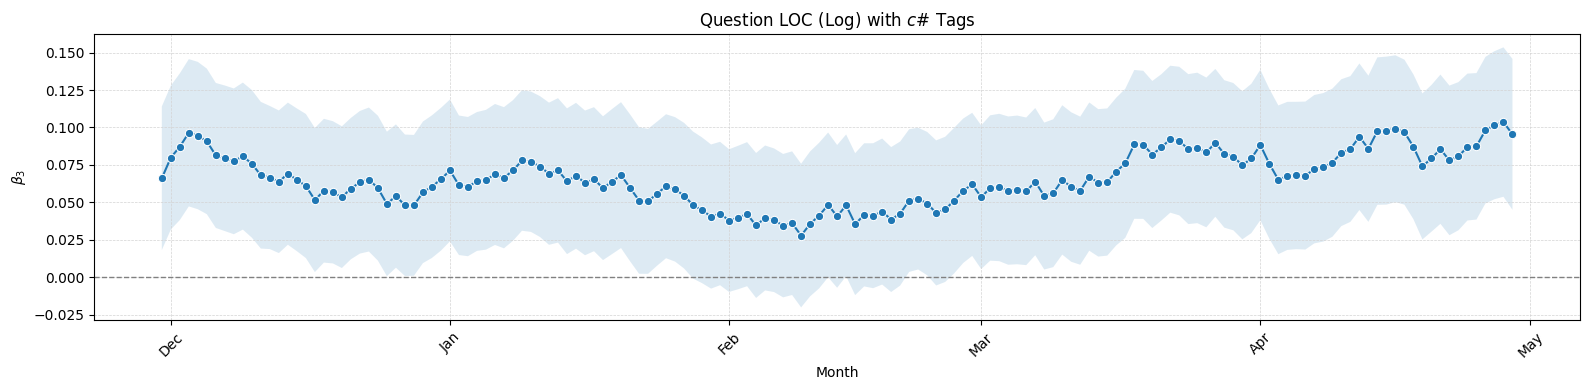

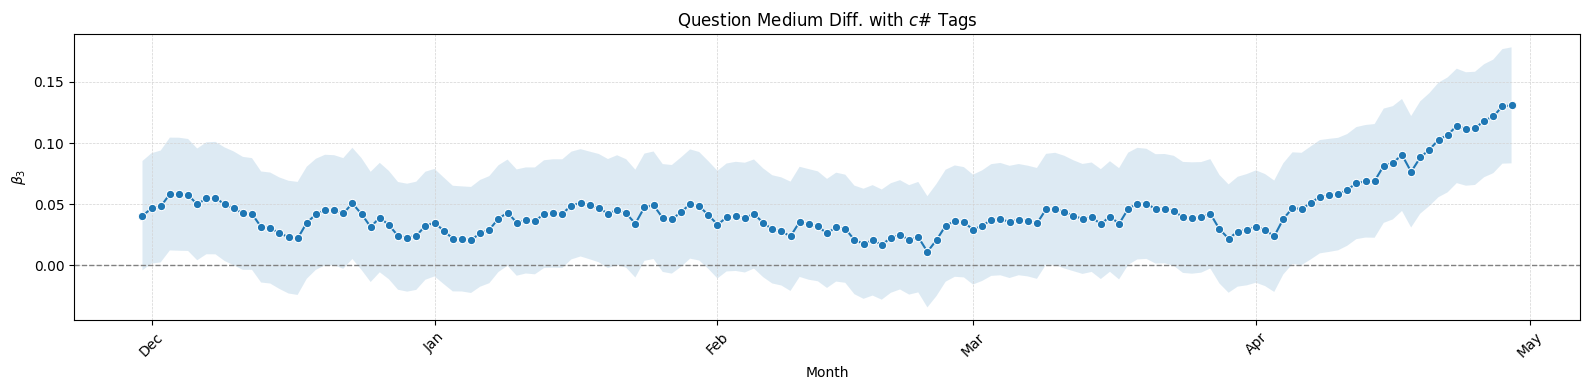

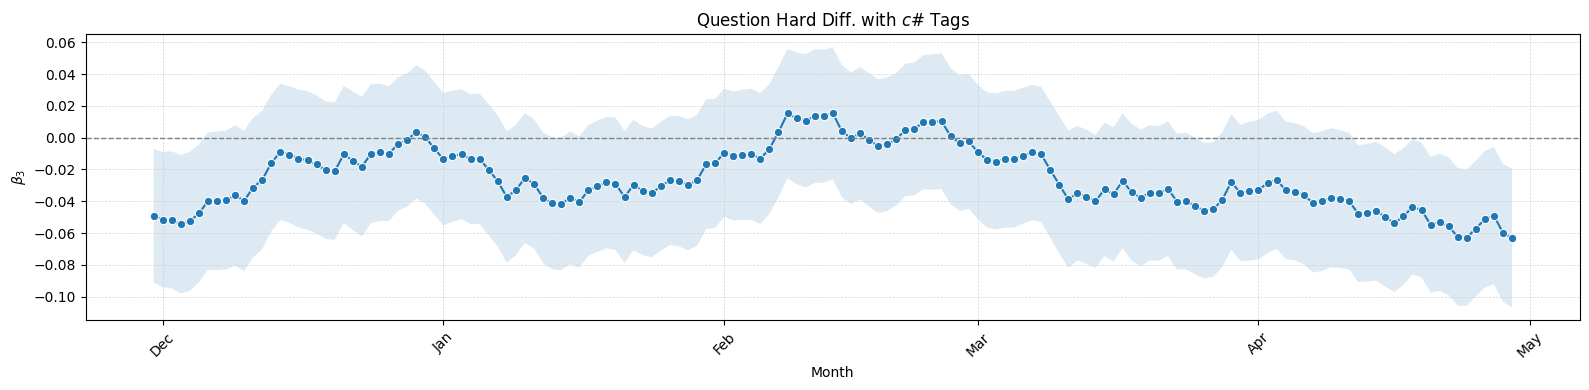

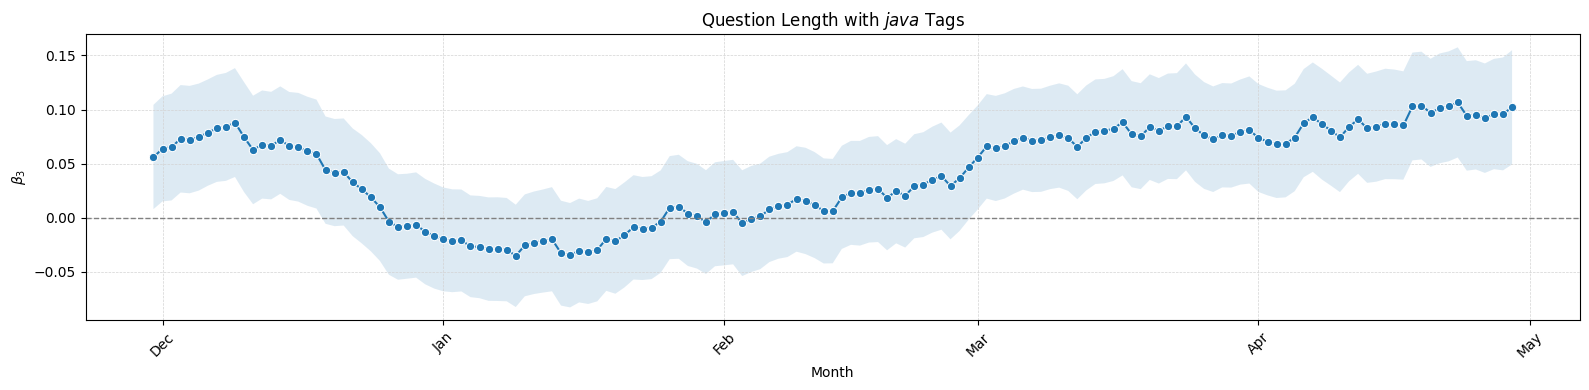

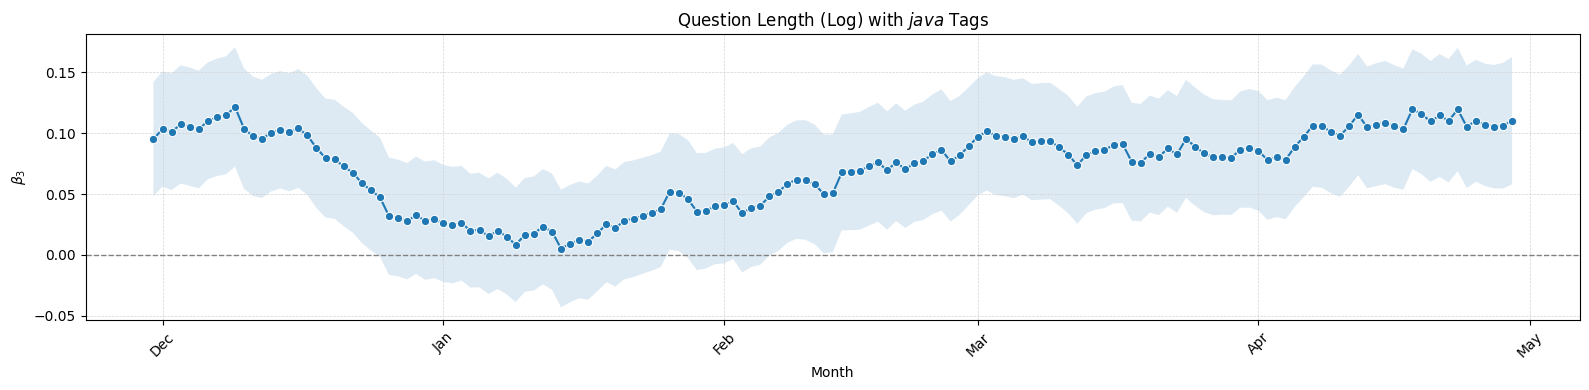

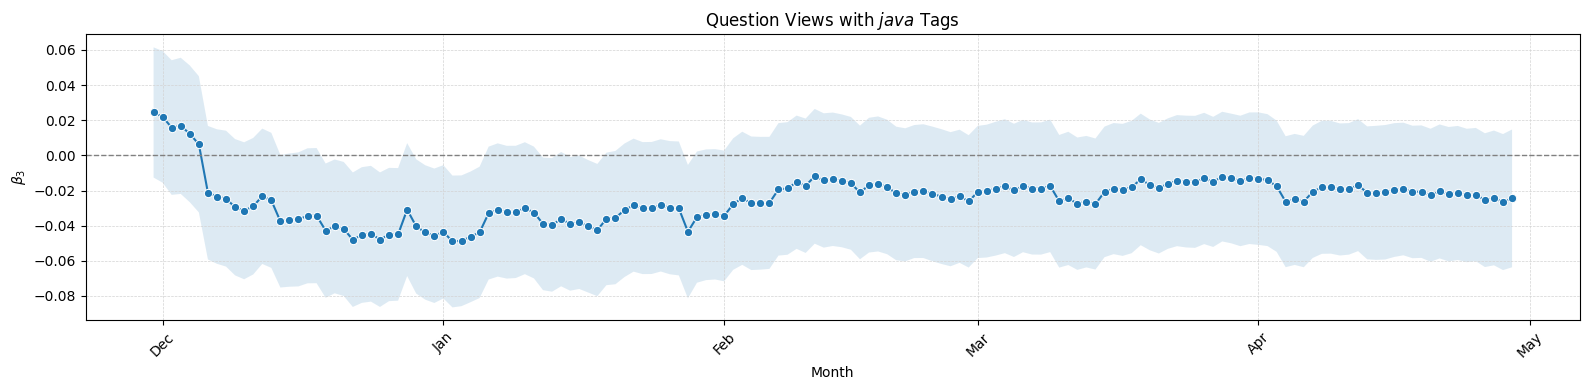

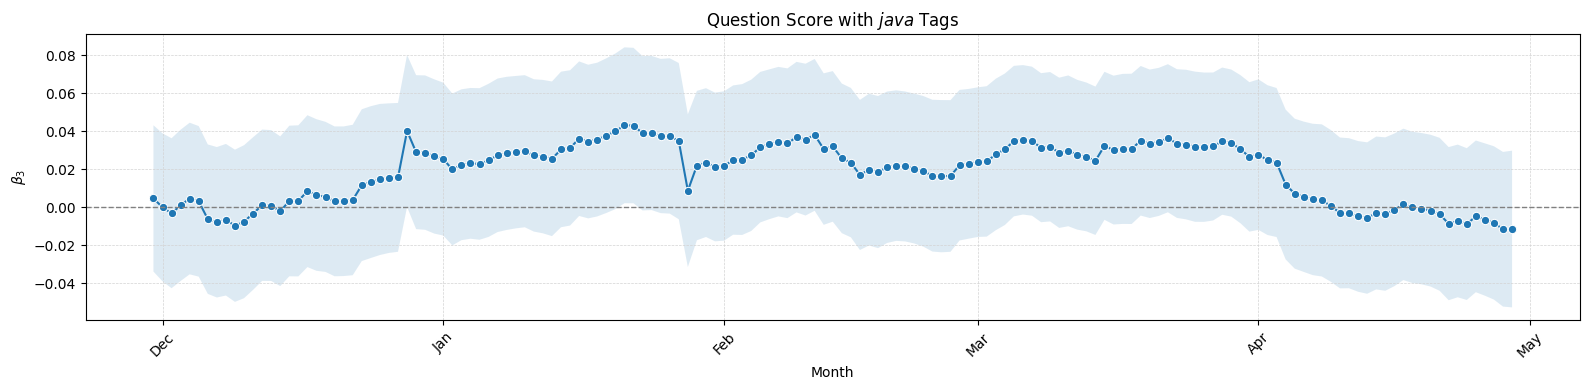

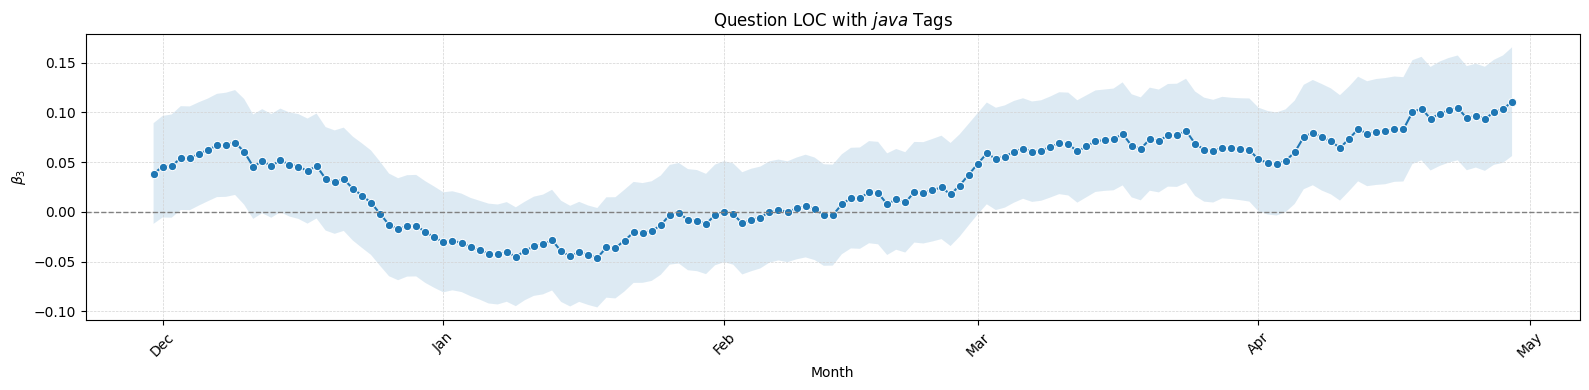

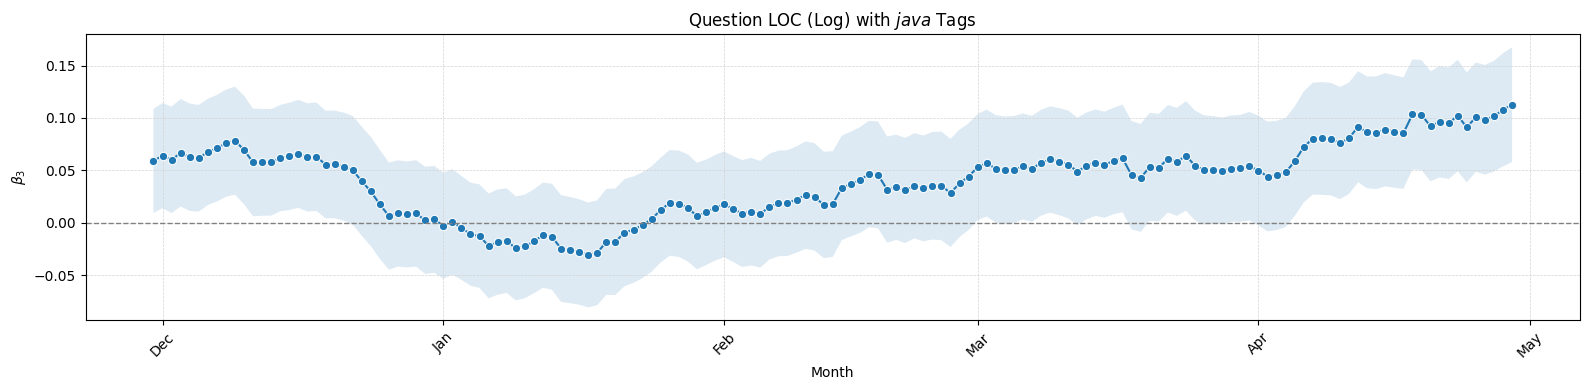

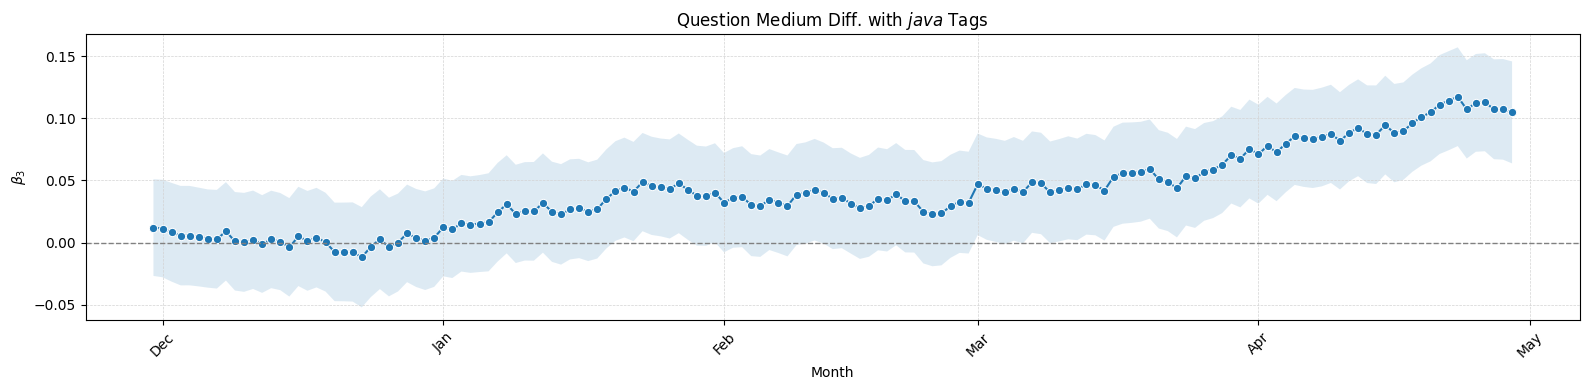

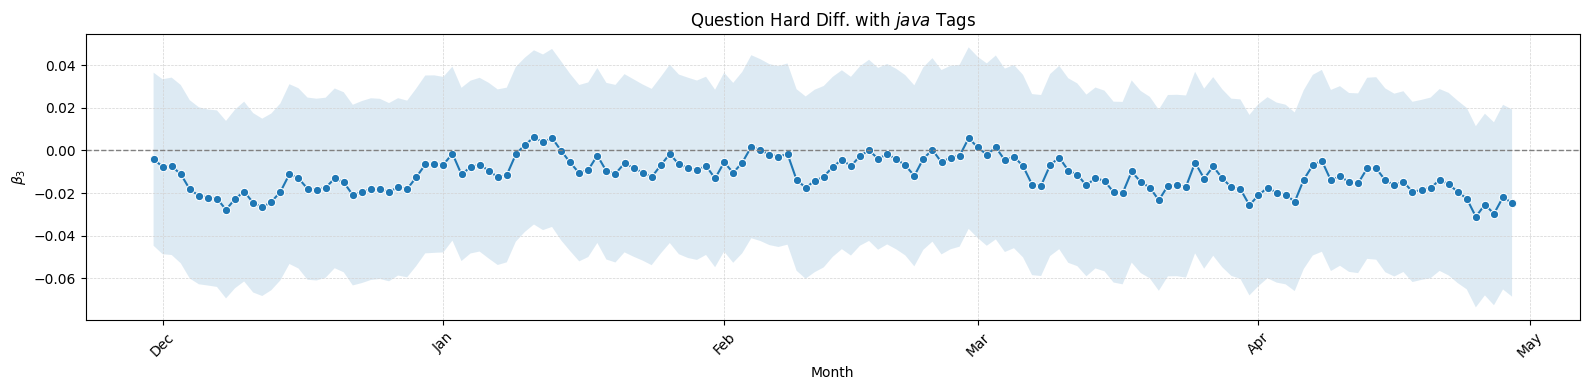

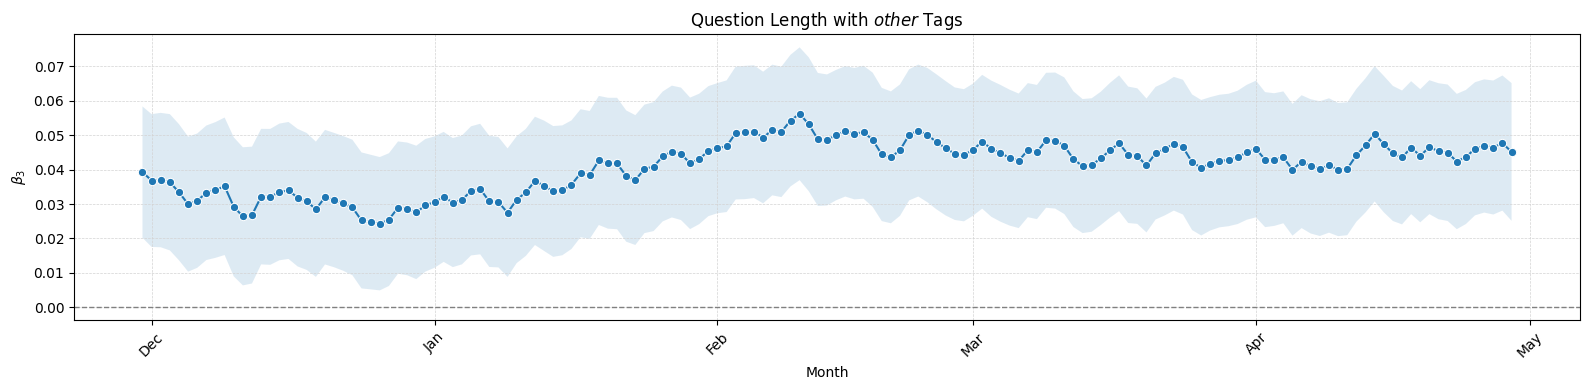

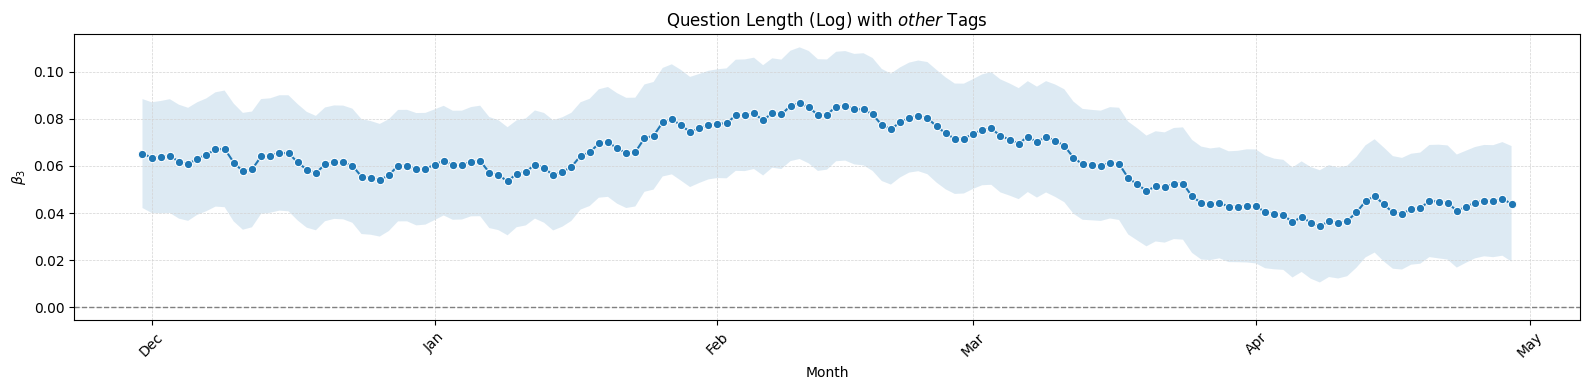

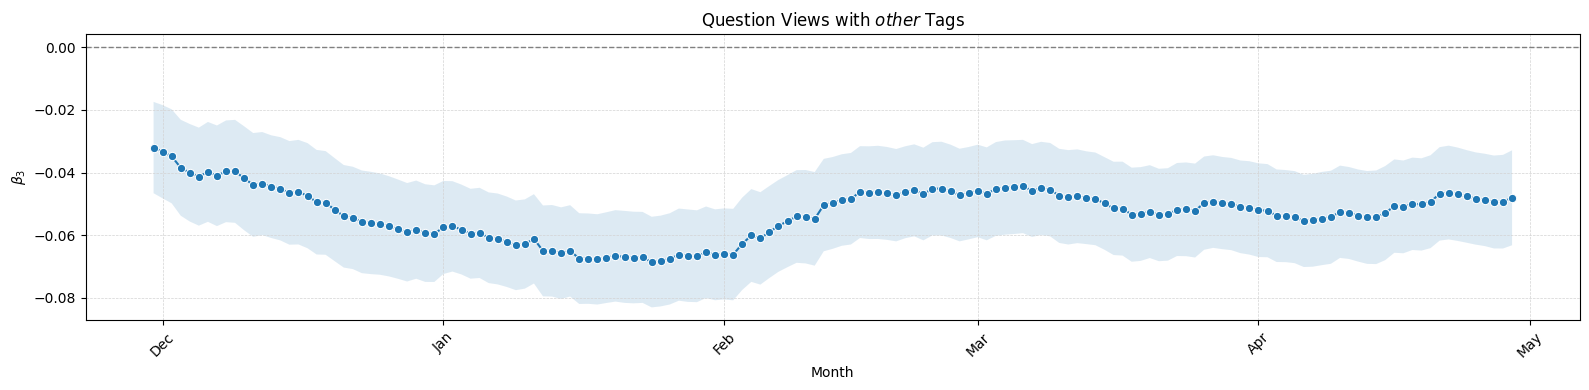

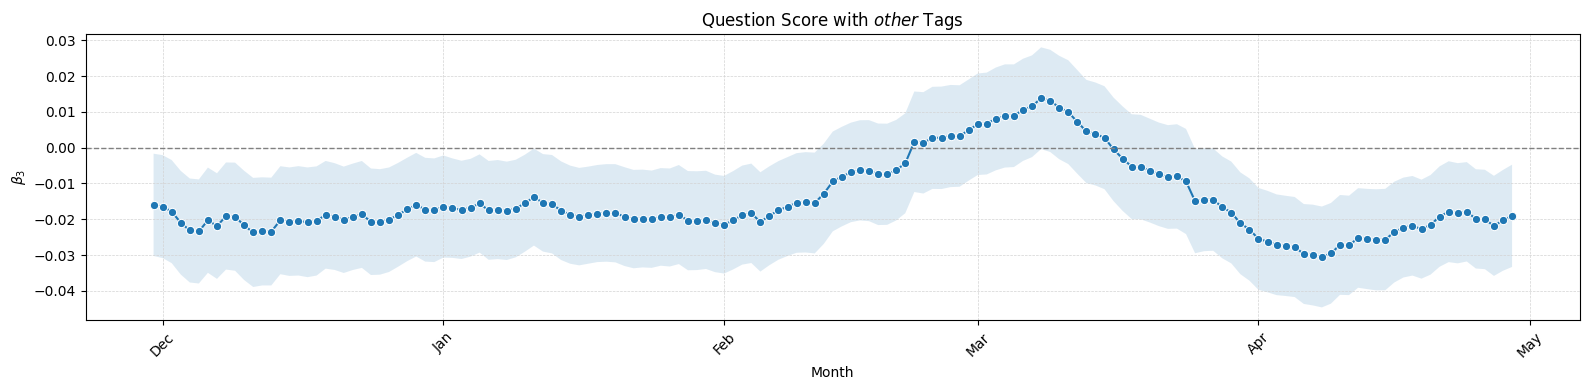

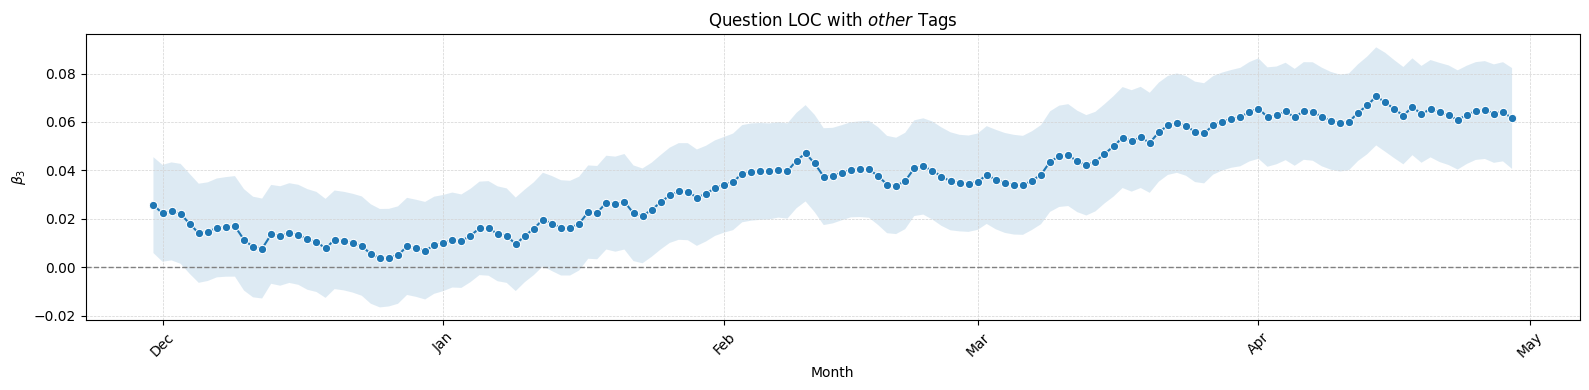

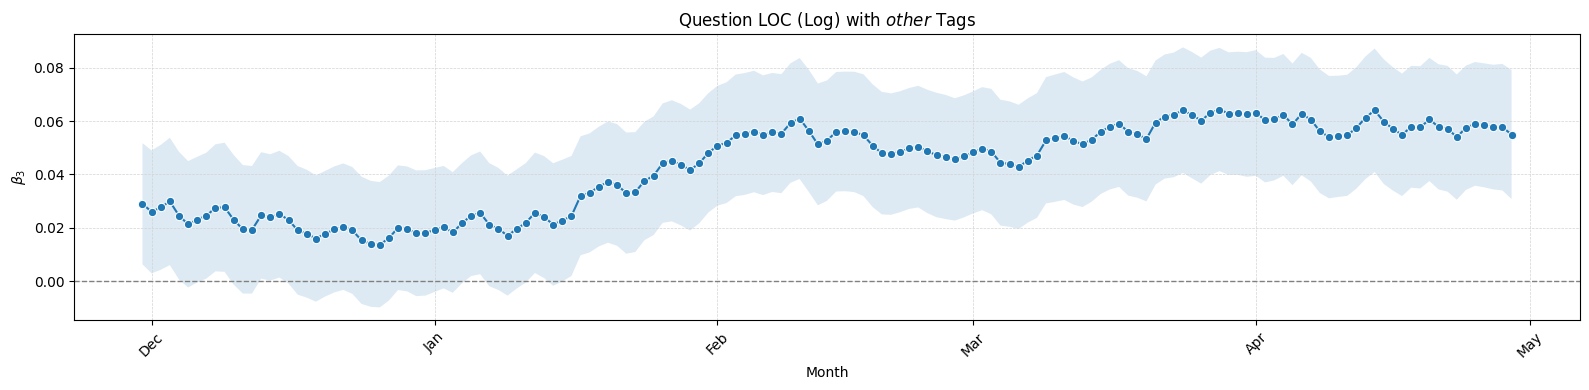

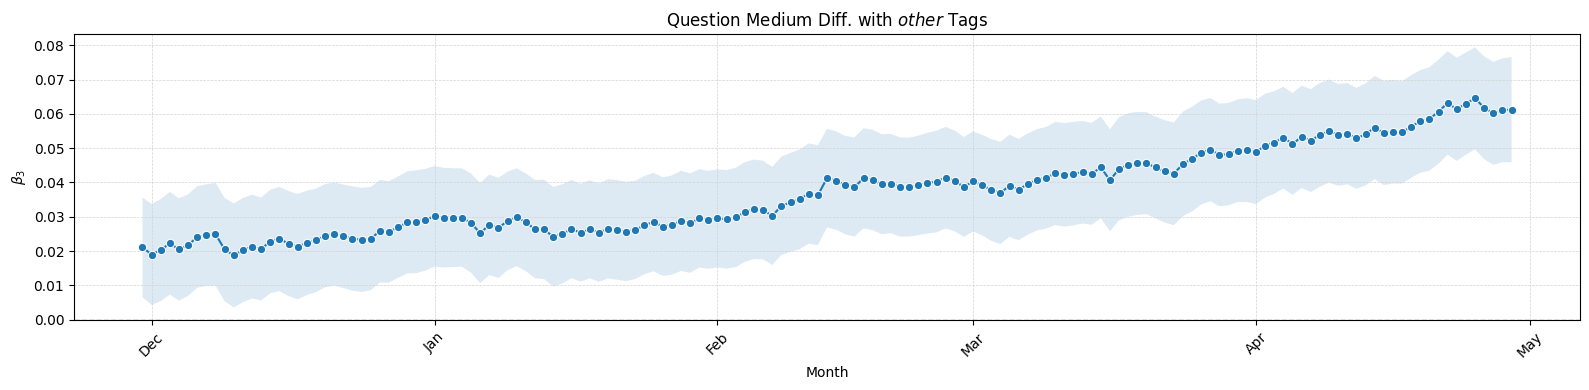

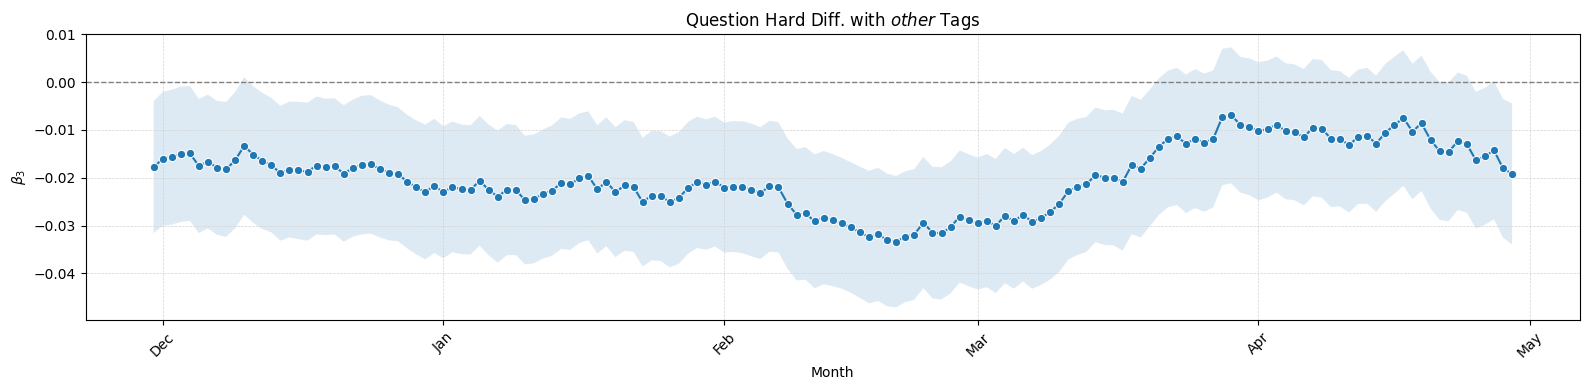

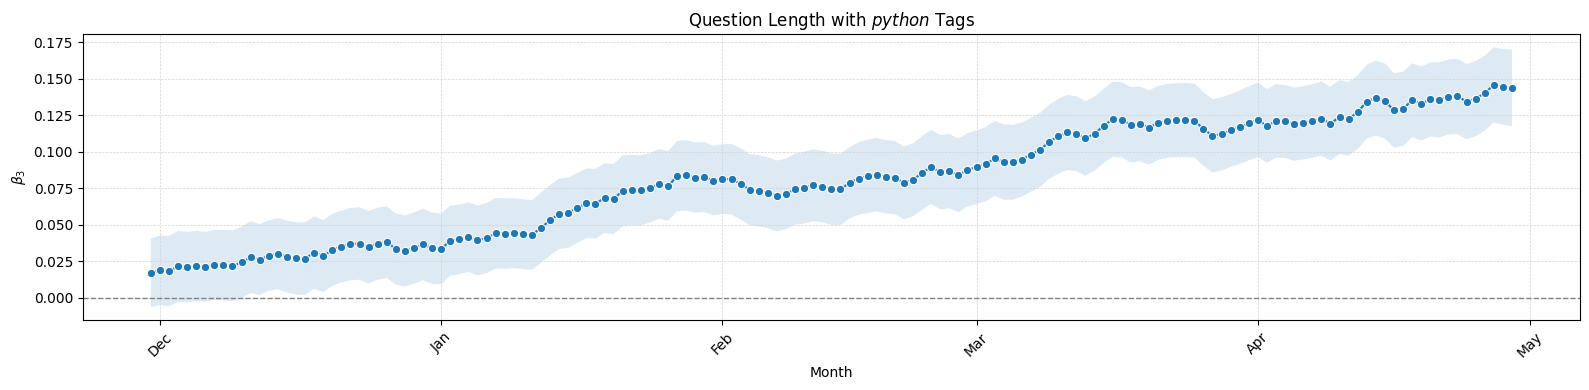

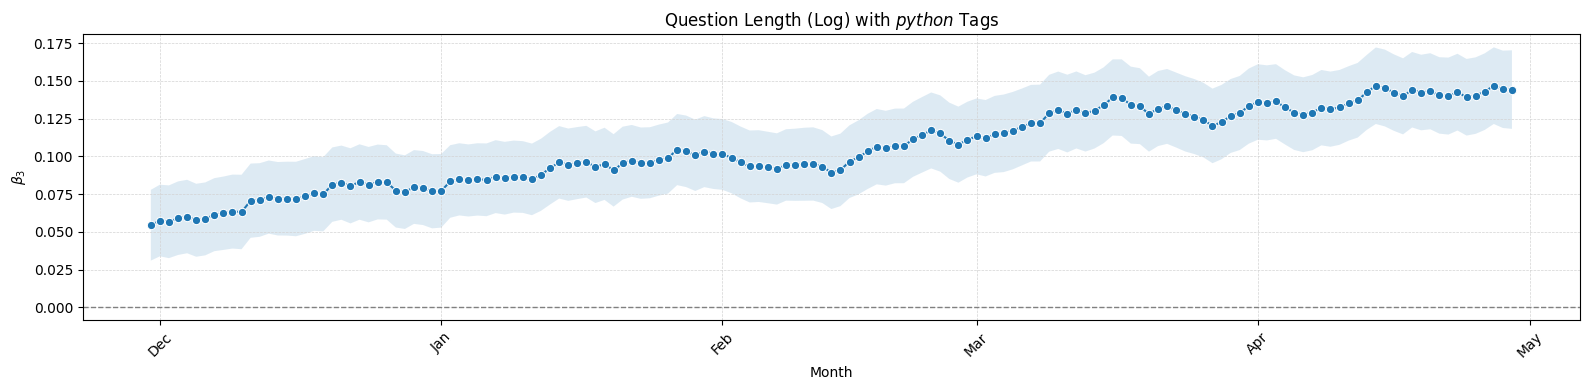

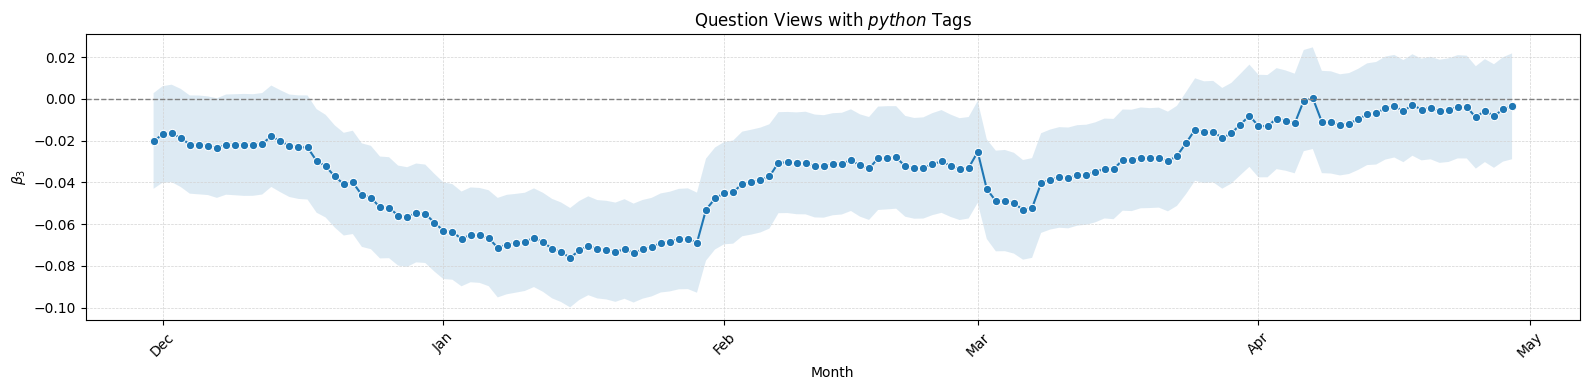

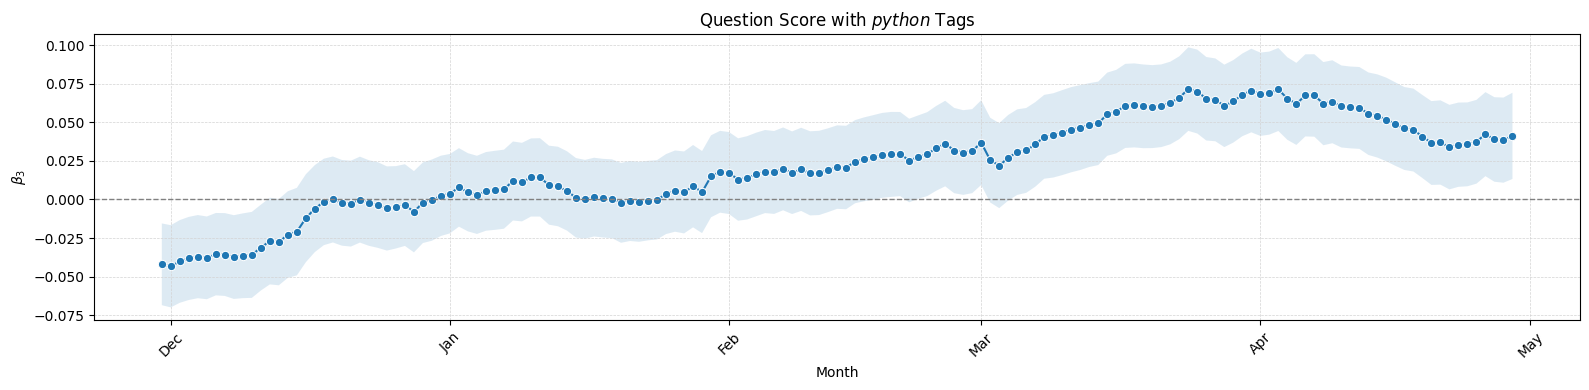

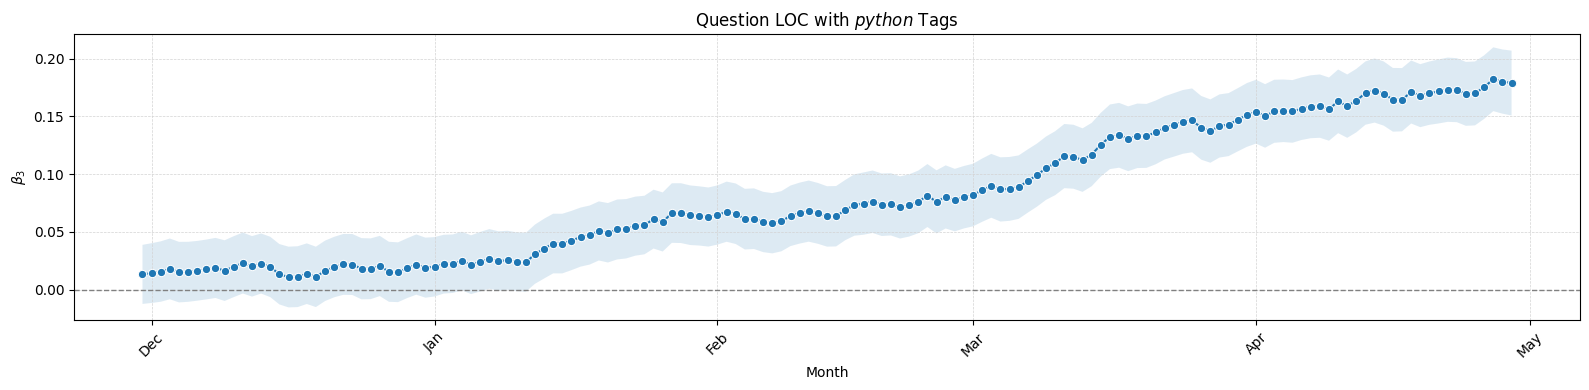

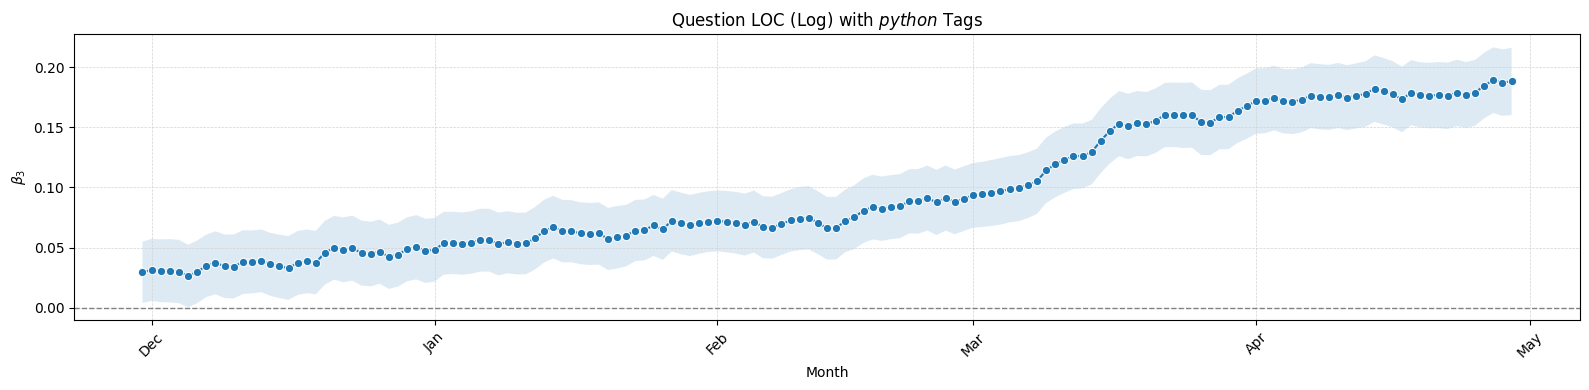

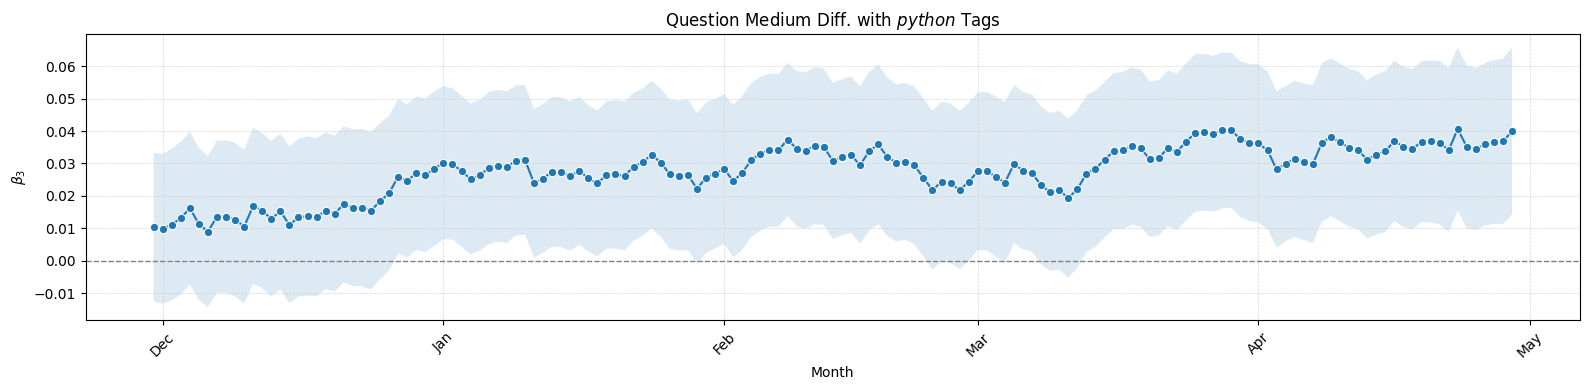

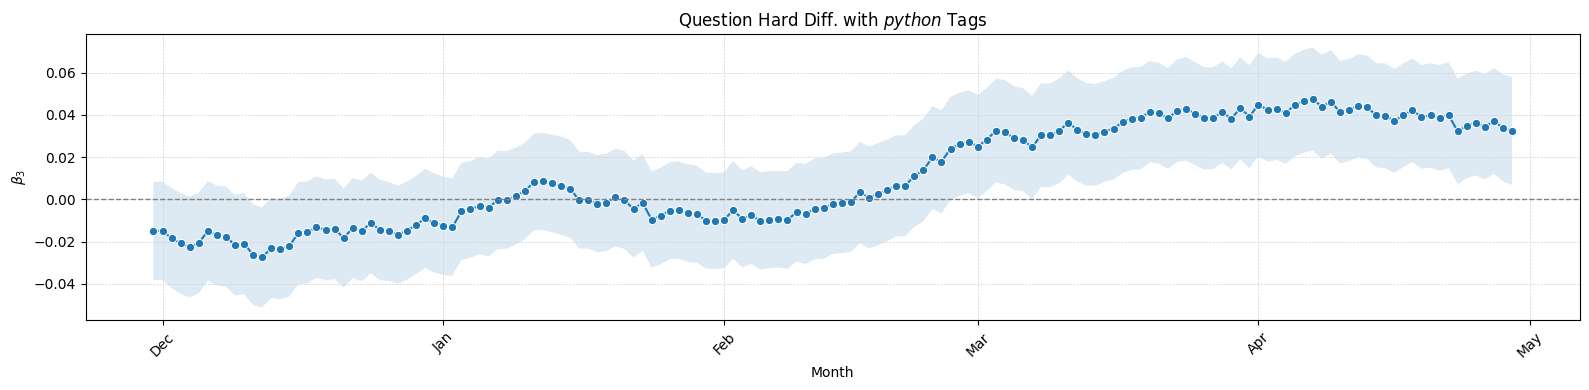

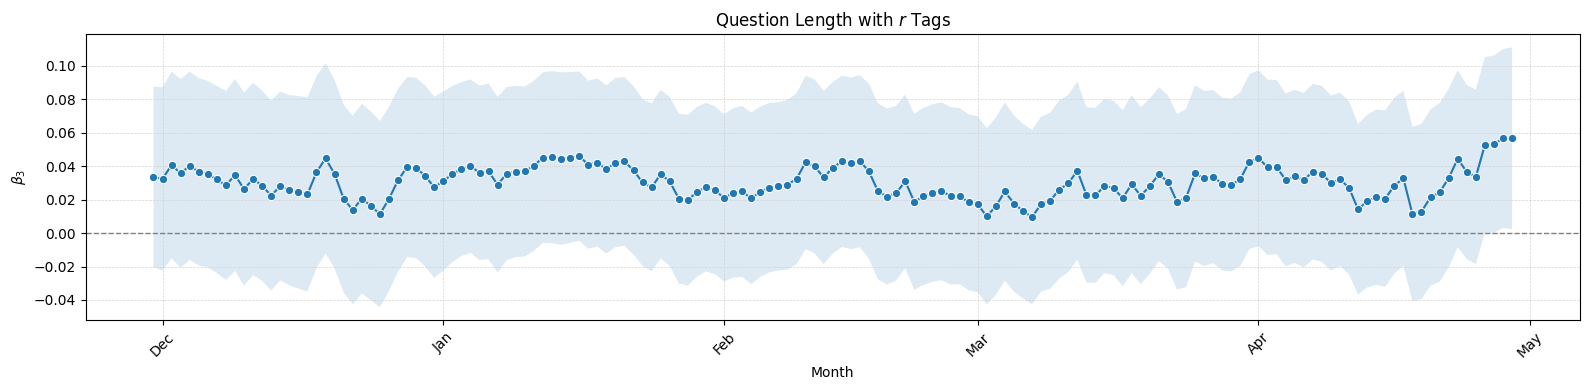

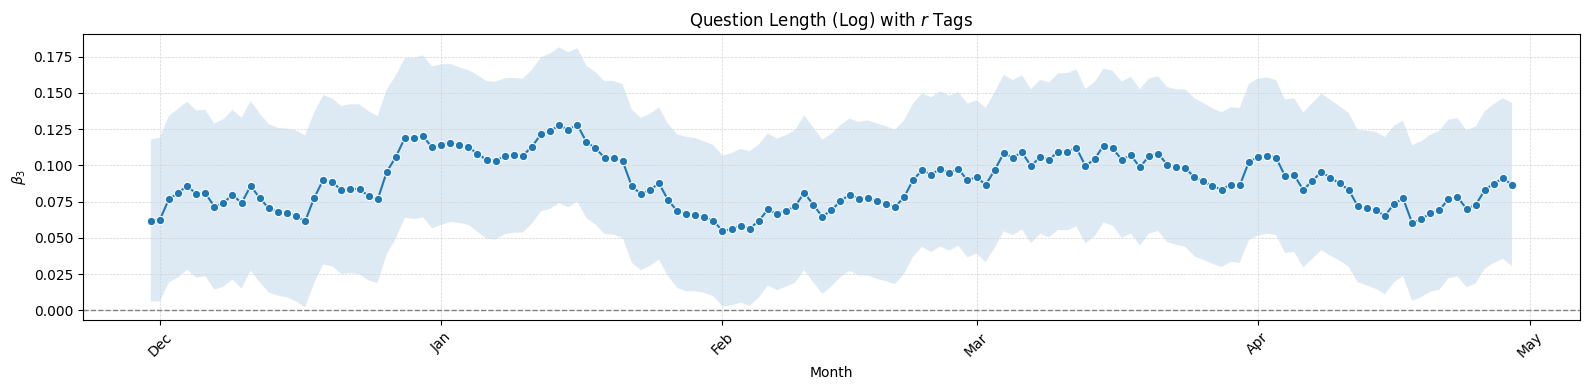

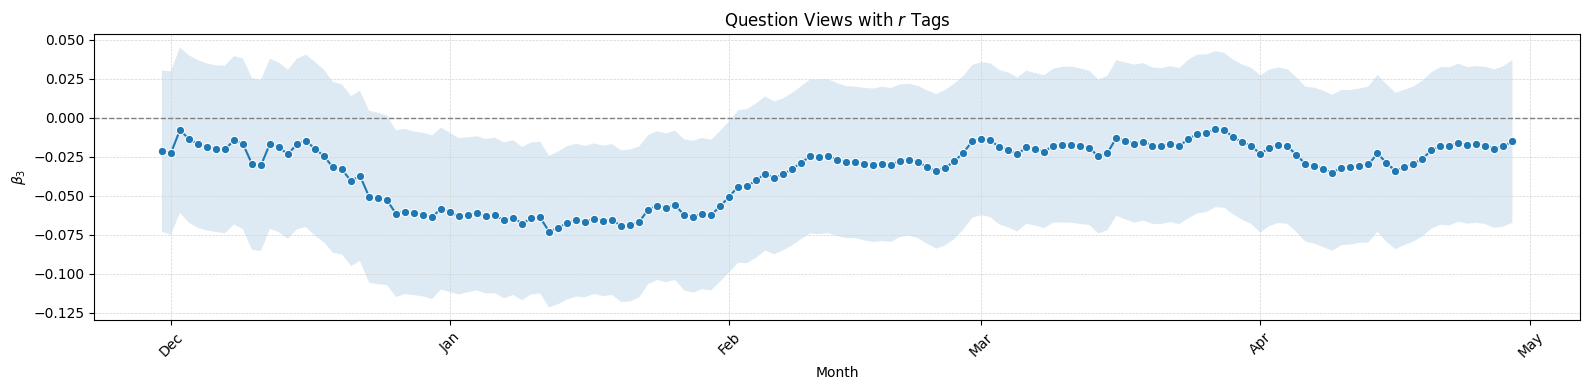

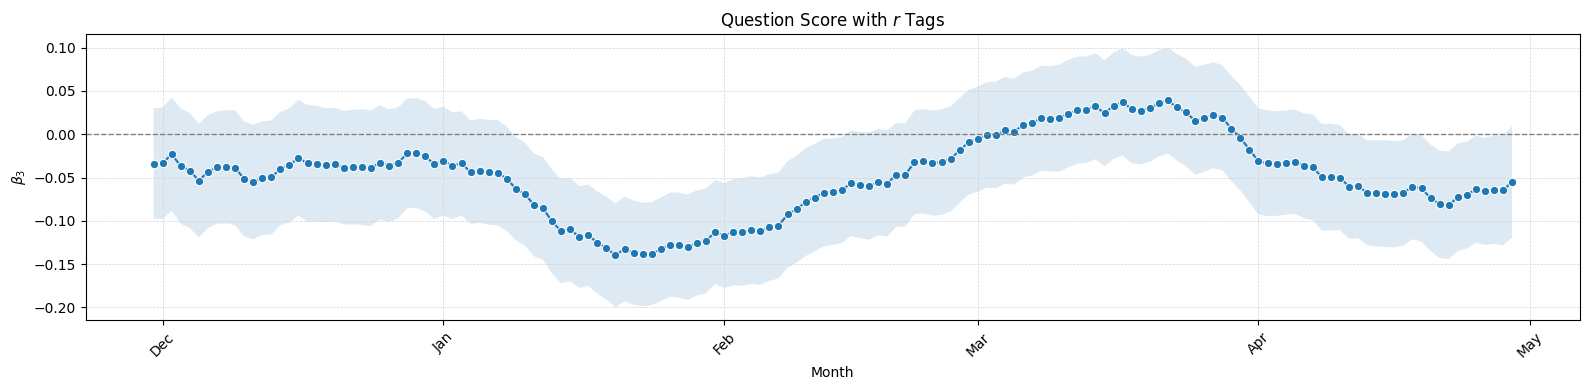

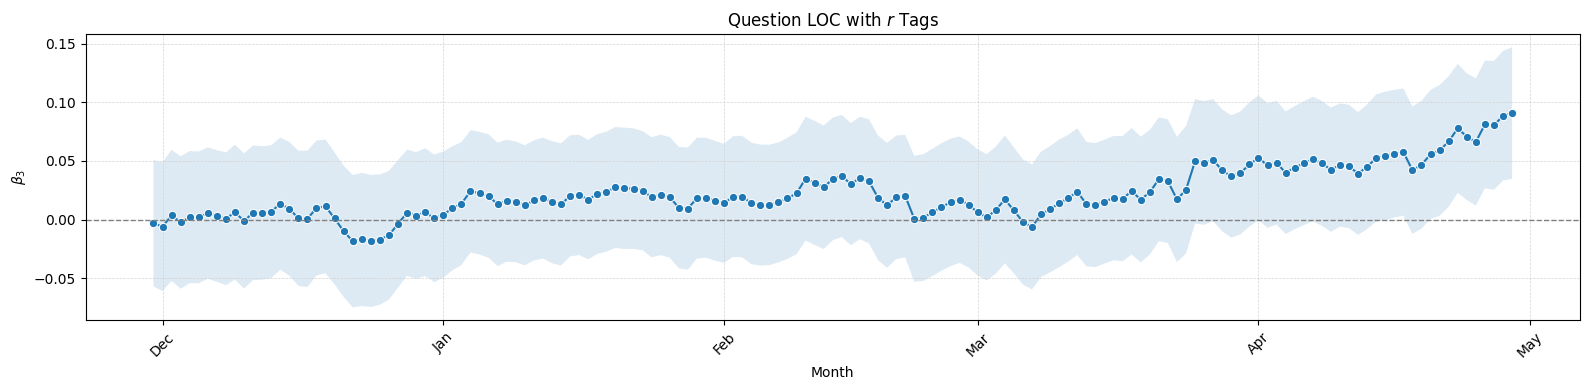

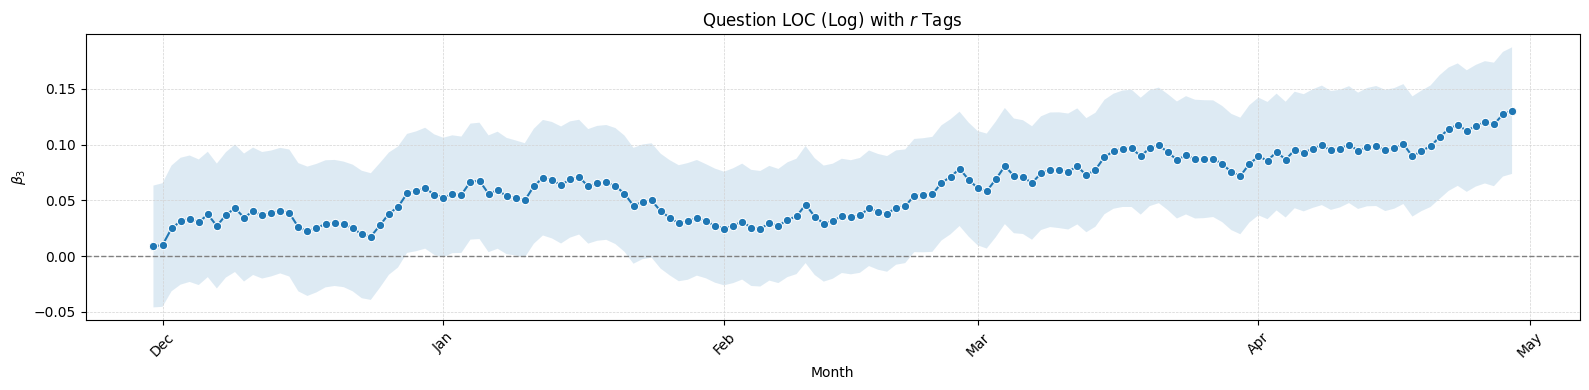

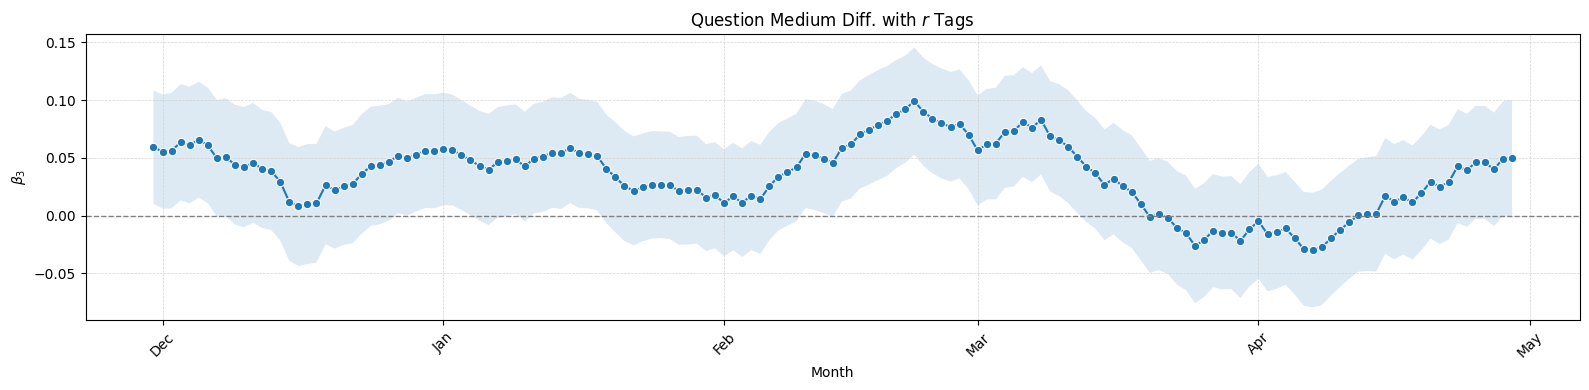

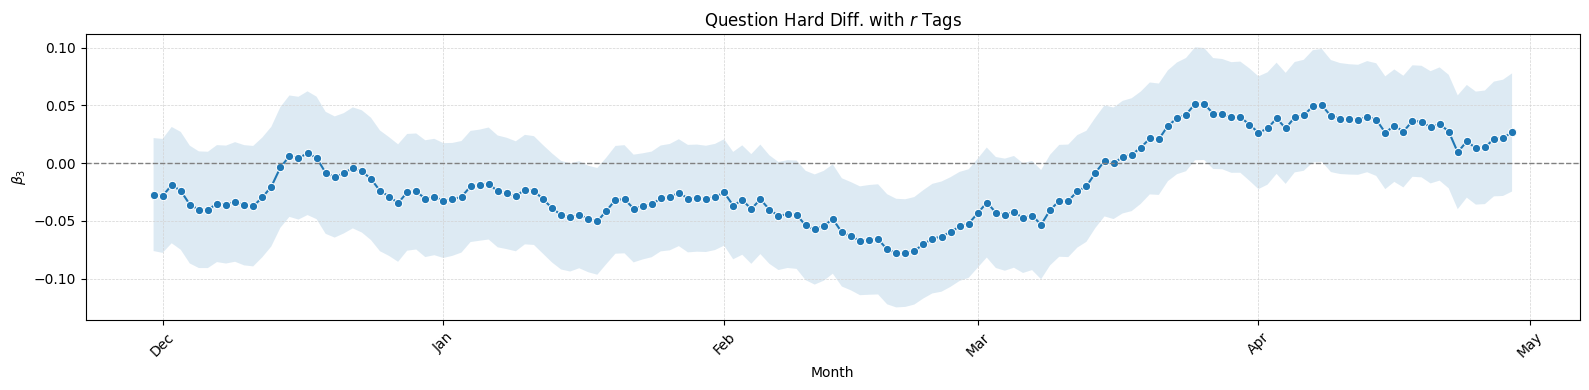

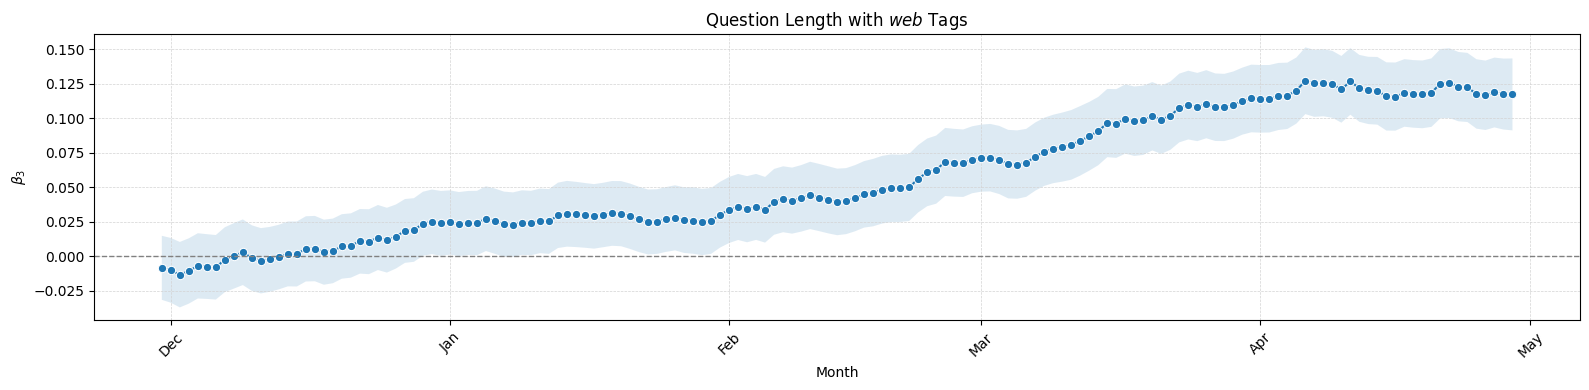

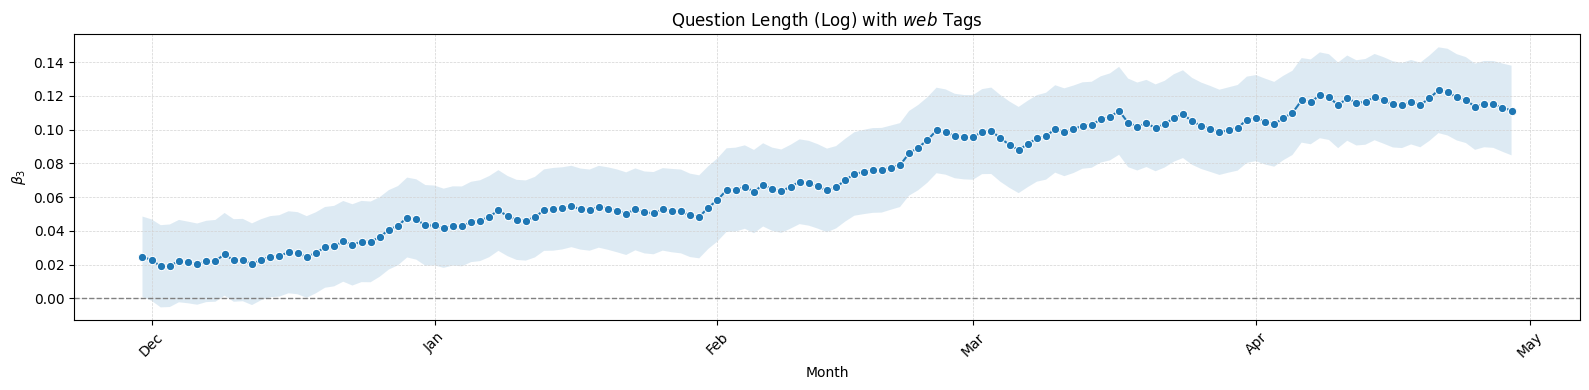

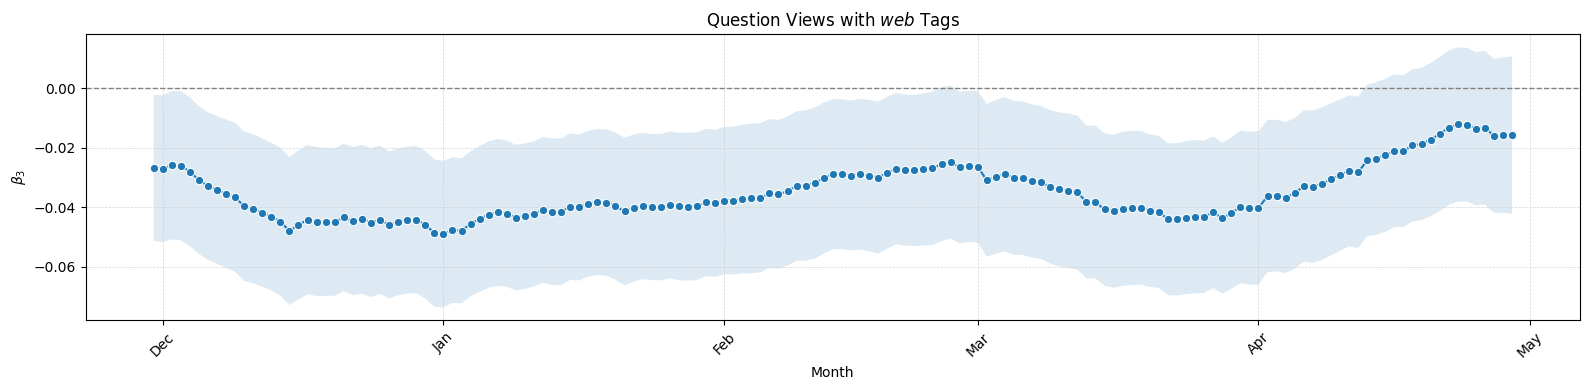

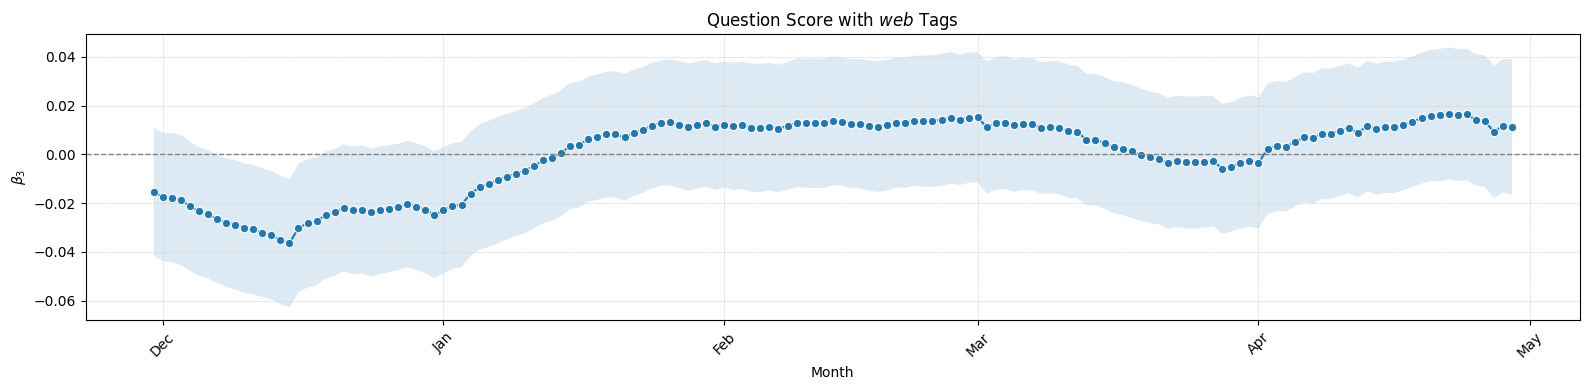

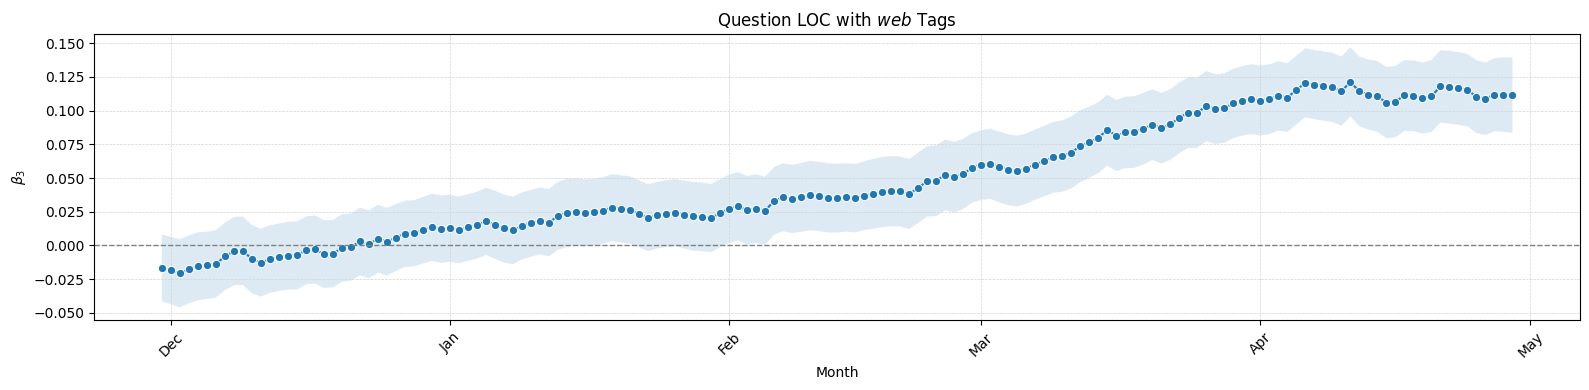

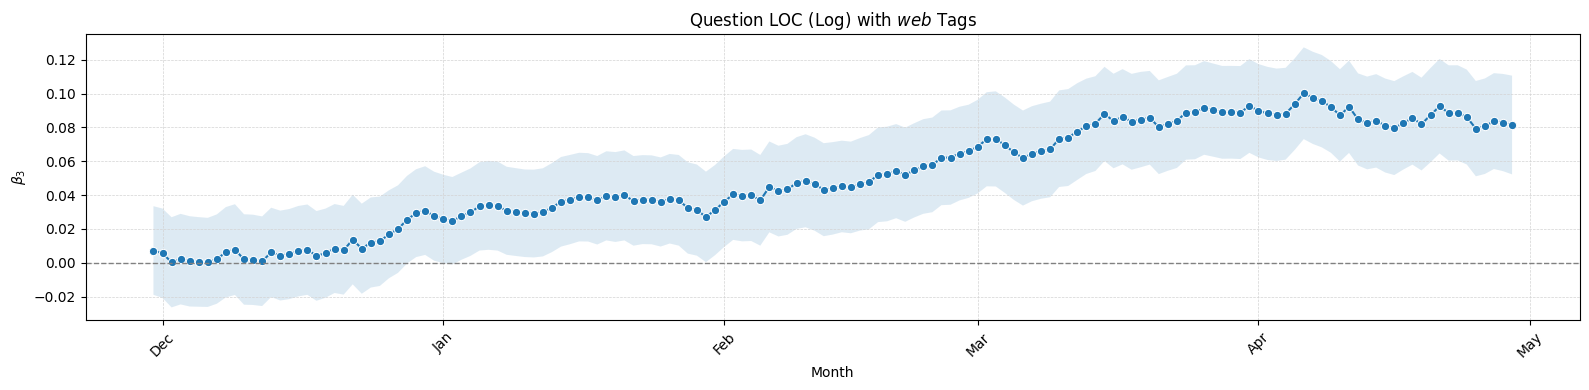

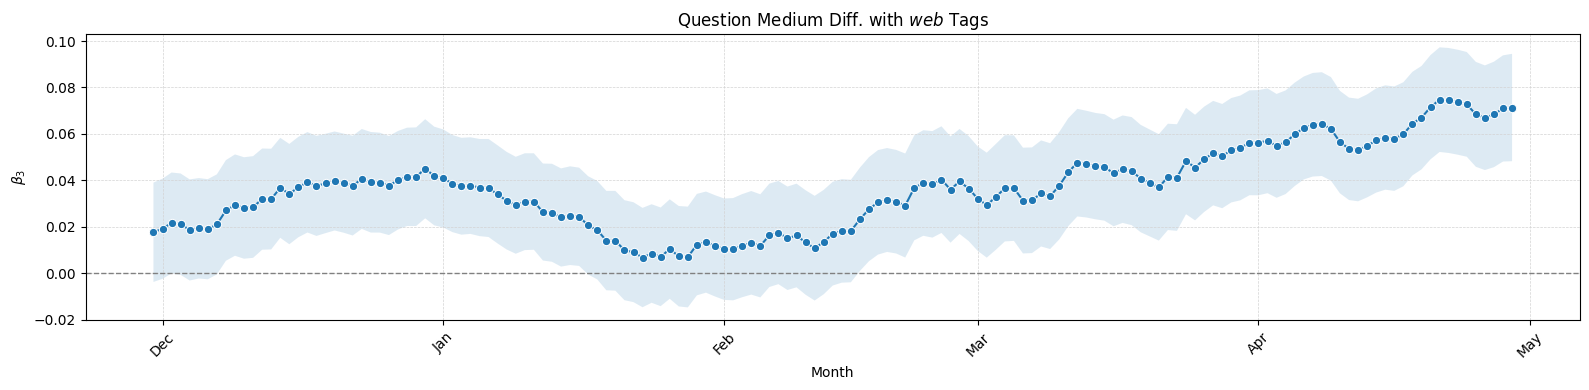

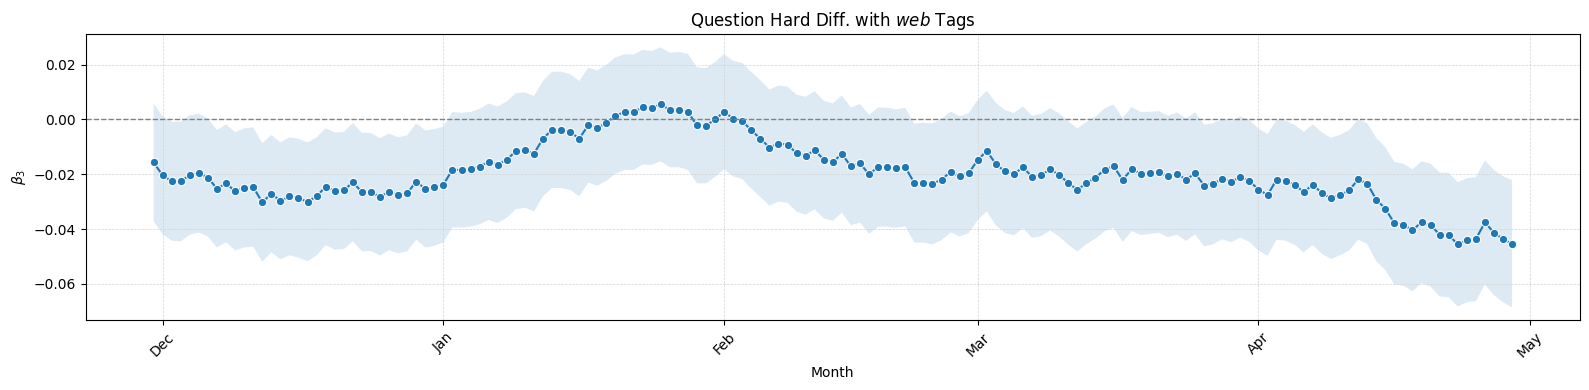

In [7]:
titles = {'line_count': ['Question Length', 'qlc_beta.pdf'],
        'log_lc': ['Question Length (Log)', 'qllc_beta.pdf'],
        'ViewCount': ['Question Views', 'qv_beta.pdf'],
        'Score': ['Question Score', 'qs_beta.pdf'],
        'loc': ['Question LOC', 'loc_beta.pdf'],
        'log_loc': ['Question LOC (Log)', 'log_loc_beta.pdf'],
        'Medium': ['Question Medium Diff.', 'medium_beta.pdf'],
        'Hard': ['Question Hard Diff.', 'hard_beta.pdf']}

for tag in tags:
    for outcome in outcomes:
        key = (tag, outcome)
        df_res = results[key]
        escaped_tag = tag.replace('#', r'\#')
        so.plot_did(df_res, rf'{titles[outcome][0]} with $\mathit{{{escaped_tag}}}$ Tags', f'tags/groups/{tag}_{titles[outcome][1]}')